# AM207 Final Project
# Practical Bayesian Optimization of Machine Learning Algorithms

**Keywords: Bayesian Optimization, Gaussian Process, Acquisition Functions**

**Collaborators: Yukun Xia, Lechen Qian, Junhan Gu**

In [4]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm

import pandas as pd
import seaborn as sns

%matplotlib inline

import pymc3 as pm

from scipy.optimize import minimize,basinhopping

from scipy.stats import norm

## Standard boilerplate to import torch and torch related modules
import torch

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [5]:
from IPython.lib.display import YouTubeVideo

from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SubsetRandomSampler

Tuning model hyperparameters, regularization terms and optimization parameters can be a black art for machine learning. In this project we explained how to develop an automatic tuning method by applying **Bayesian Optimization** and wrote the code to test the Bayesian Optimization method. We first test the theorectical reasoning of the paper using two and then apply it to MNIST dataset with neural network model to tune learning rate and regularization terms.<br/>

Paper URL: https://arxiv.org/abs/1206.2944

## Why Bayesian Optimization?

The difficulty of tuning hyperparameters in different machine learning methods led many researchers to explore different methods for hyperparameter tuning, because we cannot apply the first- and second-order methods like gradient descent, Newton’s method, or quasiNewton to the black-box objective function. Currently, basic hyperparameter tuning method includes **grid search**, **random search** or **grad student** search. However, as for the grid search, the exhaustive sampling of the hyperparameter space can be computationally expensive and quite inefficient -- the process takes many time-consuming training cycles, but still does not guarantee the best hyperparameters for the model. Random search assumes that not all the hyperparameters are equally important and focuses more on finding the optimal value for the important hyperparameter.

In this tutorial we introduce **Bayesian optimization**, a class of global optimization methods where we want to find the minimum (or maximum) of a black-box function $f(x)$ on some bounded set $\chi$. It is a type of sequential model-based optimization (SMBO) algorithms, and unlike grid search or random search, we use the results of our previous iteration to improve our sampling method of the next experiment. 

Bayesian optimization requires us to select a prior (here we choose Gaussian Process prior) and construct a probabilistic model for the objective function, then choose an acquisition function for determining the next point to sample, where we calculate the utility function from the posterior. In the following two sections we are going to introduce the **Gaussian Process** and **acquisition functions**.

## Gaussian Process

According to the definition in Wikipedia, a Gaussian process is a stochastic process, in which a collection of random variables drawn from a multivariate normal distribution indexed by time or space. The distribution over functions has a continuous domain, e.g. time or space, as Gaussian process is a joint distribution of all the random variables. 
Define some space:
Input space: $\chi$ <br/>
model scalar function:$f:\chi \to \mathbb{R}$ <br/>
Positive definite covariance function: $C:\chi \times \chi\to \mathbb{R}$<br/>
mean function: $m:\chi \to \mathbb{R}$
From what we learned on class, assume we have this function vector $f=(f(x_1),…f(x_n))$, for any choice of input points, $(x_1,…,x_n)$, the marginal distribution over $f$:

$P(F)=\int f_{f\in F}P(f)df$, is multi-variate Gaussian. Then the distribution $P(f)$ over the function $f$ is said to be a Gaussian Process.

We write a Gaussian Process thus:

$f(x)∼GP(m(x),k(x,x′))$
where the mean and covariance functions can be thought of as the infinite dimensional mean vector and covariance matrix respectively. <br/>

The figures below illustrates how we fit a GP.

<img src="images/WechatIMG2.jpeg" alt="Drawing" style="width: 400px;"/>

<img src="images/WechatIMG3.png" alt="Drawing" style="width: 400px;"/>

<img src="images/WechatIMG4.png" alt="Drawing" style="width: 400px;"/>

![](images/WechatIMG3.jpeg)

## Kernel Function and Examples of GP covariance

The learning algorithm using a Gaussian process uses a measure of the similarity between points (the kernel function) to predict the value for unseen points from the existing dataset. In the prediction, we'll not only have the information of an estimate of mean value for that point, but also has uncertainty information. These information derives from the marginal distribution at that point, which is a one-dimensional Gaussian distribution, by marginalizing over the many variables that we are not interested in.

ARD squared exponential kernel:
$$K_{SE}(\mathbf{x},\mathbf{x}') = \theta_0 exp\{-\frac{1}{2}r^2(\mathbf{x},\mathbf{x}')\}$$
where $r^2(\mathbf{x},\mathbf{x}')=\sum_{d=1}^D(x_d-x_d')^2/\theta_d^2$

In the paper the author recommended ARD Matern 5/2 kernel, which is twice differentiable but does not require the smoothness of the squared exponential.
$$K_{M52}(\mathbf{x},\mathbf{x}') = \theta_0\left(1+\sqrt(5r^2(\mathbf{x},\mathbf{x}')+\frac{5}{3}r^2(\mathbf{x},\mathbf{x}')\right)exp\left\{-\sqrt{5r^2(\mathbf{x},\mathbf{x}')}\right\}$$

## Uncertainty in Optimization

During the optimization process, the goal of each update is to find the minimum: $x^* = arg min_{x \in \chi} f(x)$. GP gives us easy closed-form of marginal means and variance. For searching the next minimum, we can do more exploration on places with high variance, but also can do more exploitation by seeking places with low means.
The acquisition functions provide a way to balance the exploration and exploitation to determine the next point to evaluate.

## Acquisition Function

We can solve the aforementioned tradeoff of **exploitation** (the mean is low) and **exploration** (the variance is high) with the **acquisition function**.The prior and existing datapoints induce a posterior over functions: the acquisition function, and the goal is the evaluate the points and move to the point which maximize the acquisition function. Several different functions have been proposed. We evaluated all three aqcuisition funstion proposed by author and recommend Expected Improvement. <br/>

**Denotation:**<br/>
Acquisition functions depend on the previous observations and GP hyperparameters: $a(x ; \{x_n, y_n\}, \theta)$. <br/>
Under the Gaussian process prior, these acquisition functions depend on the model solely through its predictive mean function $\mu(x ; \{x_n, y_n\}, \theta)$ and predictive variance function $\sigma^2(x ; \{x_n, y_n\}, \theta)$<br/> 
$\Phi(·)$ will denote the cumulative distribution function of the standard normal.<br/>
$x_b$ denote the point which has current best value.

Authors proposed three types of acquisition function in the paper:<br /> 
(1) **Probability of Improvement `PI`**. The rationale of this strategy is to maximize the probability of improving over the best current value (Kushner, 1964), by integrating the pdf of marginal normal distribution from minus infinity to the point($x_b$) where resides the best current value. Under the GP this has closed form:
$$a_{PI}(x ; \{x_n, y_n\}, \theta) = \Phi(\gamma(x))$$
$$ \gamma(x) = \frac{f(x_{b}) − \mu(x ; \{xn, yn\}, \theta)}{\sigma(x ; \{x_n, y_n\}, \theta)}$$<br /> 

However, we employed this strategy in acquisition function to evaluate points, end up realizing it's quite unstable and inefficient in finding global minimum. The process of minizing the acquisition function will be stuck at saddle points, where nearly zero gradient disables the algorithm to descend. <br/>

(2) **GP Lower Confidence Bound `LCB`**. Based on this idea, we are supposed to harness the lower confidence bounds (upper, when considering maximize the value of the acquisition function) to find the next point with lowest value. The acquisition functions have this following analytical form
$$a_{LCB}(x ; \{x_n, y_n\}, \theta) = \mu(x ; \{x_n, y_n\}, θ\theta) − \kappa \sigma(x ; \{x_n, y_n\}, \theta)$$,
with a tunable $\kappa$ to balance exploitation against exploration.<br />

After our test, this acquisition function can facilitate the model to perform well.<br/>

(3) **Expected Improvement `EI`**. This acquisition function was selected by authors of the paper by maximizing the expected improvement (EI) over the current best, and they claim that this could be better-behaved than probability of improvement, and not require one more tuning parameter $\kappa$ in LCB. The closed form under the Gaussian process:
$$a_{EI}(x ; \{x_n, y_n\}, \theta) = \sigma(x ; \{x_n, y_n\}, \theta) (\gamma(x) \Phi(\gamma(x)) + \mathcal{N} (\gamma(x) ; 0, 1))$$

We show the derivation of the formula as follows:

$$
\begin{align}
a_{EI}(x ; {x_n, y_n}, \theta)  &=\int_{-\infty}^{f(x_b)}[f(x_b)-f(x)] p(f(x))dx\\
& = f(x_b)\int_{-\infty}^{f(x_b)}p(f(x))dx - \int_{-\infty}^{f(x_b)}f(x)p(f(x))dx\\
\end{align}
$$

Denote the left part as $LP$ and the right part as $RP$, then look at seperately:

LP term：
$$
\begin{align}
&f(x_b) = \sigma(x;\{x_n, y_n\}, \theta)\gamma(x)+\mu(x;\{x_n, y_n\}, \theta)\\
&\int_{-\infty}^{f(x_b)}f(x)p(f(x))dx = \Phi(\gamma(x))\\
&\therefore  LP = \sigma(x;\{x_n, y_n\}, \theta)\gamma(x)\Phi(\gamma(x))+\mu(x;\{x_n, y_n\}, \theta)\Phi(\gamma(x))\\
\end{align}
$$
RP term：$\sigma(x;\{x_n, y_n\},\theta)$ as $\sigma$, $\mu(x;\{x_n, y_n\},\theta)$ as $\mu$
$$
\begin{align}
&f(x) p(f(x) = \frac{f(x)}{\sqrt{2\pi\sigma^2}}e^{-\frac{(f(x)-\mu)^2}{2\sigma^2}})\\
&\therefore RP = \int_{-\infty}^{f(x_b)}f(x)p(f(x))dx = -\frac{\sigma}{\sqrt{2\pi}}e^{-\frac{(f(x)-\mu)^2}{\sqrt{2\sigma^2}}}+\mu\Phi(\gamma(x))\\
\end{align} 
$$
Then we'll have
$$
\begin{align}
LP-RP &=\sigma(x;\{x_n, y_n\}, \theta)\gamma(x)\Phi(\gamma(x))+\mu(x;\{x_n, y_n\}, \theta)\Phi(\gamma(x))+\frac{\sigma}{\sqrt{2\pi}}e^{-\frac{(f(x)-\mu(x))^2}{\sqrt{2\sigma^2}}}\\
&=\sigma(x;\{x_n, y_n\}, \theta)\gamma(x)\Phi(\gamma(x))+\mu(x;\{x_n, y_n\}, \theta)\Phi(\gamma(x))+\mathcal{N}(\gamma(x);0,1) \\
& = \sigma(x)[\gamma(x)\Phi(\gamma(x))+\mathcal{N}(\gamma(x);0,1)]
\end{align} 
$$

$$
\therefore a_{EI} = \sigma(x;\{x_n, y_n\}, \theta)[\gamma(x)\Phi(\gamma(x))+\mathcal{N}(\gamma(x);0,1)]
$$

<img src="images/WechatIMG5.jpeg" alt="Drawing" style="width: 400px;"/>

<img src="images/WechatIMG6.jpeg" alt="Drawing" style="width: 400px;"/>

The above two figures explain how the acquisition function works. We fit a GP using the existing data points to get a model for the function. We plot the acquisition function at the bottom of the plot and find the $x^*$ that maximize the acquisition function as the next point to sample, which reduce the uncertainty (sample the places with highest variance) and exploit the range with lowest mean. We keep sampling until we find the optimum.

## Coding Time!

Based on the idea of this paper, we coded the Bayesian Optimization method `BayeOpt` to implement practical Bayesian optimization. `pymc3` and `scipy.optimize` are utilized for sampling and optimization in the model.<br/>

We first provide an intuitive intepretation: We initialize our model with hyperparameters $\lambda$, and score $v$ to it after training. Next, we use the previously evaluated hyperparameter values to compute a posterior expectation of the hyperparameter space. We can then choose the optimal hyperparameter values according to this posterior expectation as our next model candidate. We iteratively repeat this process until converging to an optimum. 

The algorithm can be written as below.

> **Bayesian Optimization Algorithm `BayeOpt`**
1. for t=1,2,... do
2. Find $x_t$ by combining attributes of the posterior distribution in an acquisition function u and maximize
$$x_t = argmax_x a(x|\mathcal{D})$$
3. Sample the objective function
4. Augment the data $\mathcal{D}_{1:t} = \{\mathcal{D}_{1:t-1},(x_t,y_t)\}$ and again fit the GP.
5. end for

In the following part, we'll quickly walk through our model and code.<br/>

The `target_func` is the function that we want to optimize by the method introduced in this paper. `x_range` is the range of domain of traget function. Gaussian process would require several points for initialization. In our model, the defalt setting of initial `x` points are the x value of two ends of the domian and the point lying in the middle. Additional inital points can be added by giving value to parameter init_points, e.g., init_points = 3 means three extra initiation points will be included, which would probably lead to better performance of the optimization process.<br/> 

Kernel function `kernel`, in another word, covariance function is crucial for Gaussian process to represent a large repotoire of distributions of function. A common practice is that people use the automatic relevance determination (ARD) squared exponential kernel for Gaussian process regression. However, the concern is that sample functions with this covariance function are too smooth for real world optimization problems. As suggested by the author of this paper, we'll choose Matern52 as our kernel, which is twice differentiable. The rationale behind this is this kernel can make sample functions corresponds to those made by quasi-Newton methods, and more close to real-world situation.

Hyperparameters in Gaussian Process. We need to distinguish the hyperparameters subjected to the overall Bayesian optimization and the hyperparameter we set for Gaussian process, which govern its behavior. For $D$ dimension space of target function, we would have $D + 3$ Gaussian process hyperparameters: $D$ length scales $\theta$, the covariance amplitude $\theta_0$, the observation noise $ν$, and a constant mean $m$. We tested several prior distribution of $\theta_0$ and $\theta$, including **Half-Cauthy, Gamma, exponantial**. 

We found sampling a point close to one will lead to error in the model, we seek to use Gamma as prior distribution since give less chance to sample a point near zero, in comparison with Half-Cauchy distribution. As tested, Half-Cauchy gives extremely unstable performance and failed the task frequently, we prefer to use Gamma distribution as prior for $\theta_0$ and $\theta$， with the merits that it rectifies itself before going to far in the wrong direction. And the initiation strategy for prior distribution is $\nu=1$,$theta_0=1$,$theta_1=1$.<br/>


Optimization method and its corresponding acquisition function can be specified in the function `Sampling.Sampling(self,mode,acquisition)`<br/>
Choises for mode: <br/>
`Opt` represent optimization, which is a common approach by leveraging a point estimate of these parameters through optimizing the marginal likelihood under the Gaussian process and find the MAP. It mathmatical expression is as follows:$$P(y|\{x_n\}_{n=1}^N, \theta, v, m) = \mathcal{N}(\mathbf{y}|m\mathbf{1}+\mathbf{\Sigma}_\theta+v\mathbf{I})$$,where $Σ\theta$ is the covariance matrix resulting from the N input points under the hyperparameters $\theta$.<br/>

`MCMC` represent a sampling method by Markov Chain Monte Carlo. N samples will be drawed by a GP model we developed on pymc3. <br/>

Using subfunction `acq(x_star)`, where `x_star` represent a vector of points, we can evaluate these points by applying one of the learning policy of acquisition function: PI, EI or LCB. From there, we'll choose the point of minimal value to become the next point, which will be implemented by subfunction `Get_next`.<br/>

function `Iteration` is a main function which incoparate these subfunction to implement the bayesian optimization task. Everytime, among all the new pool of points being evaluated, the point with best maximal acquisition value will be taken and incorparate into existing datapoints. Max number of iterations can be set and the algorithm will automatically stop optimizing when the step of a move towards a new point is strictly smaller then the 0.01% of the range of the domain. To prevent the algorithm from getting trapped in the local minimum or saddle point, "x new is old!" warning message will appear and the optimization process stops when the next point choose by the algorithm remain unaltered from the previous one.<br/>

For simple yet elegant demonstration, we choose two functions $g(x)=x^2$ and $f(x,y)=x^2+y^2$ as target function, and evaluate the performance of our algorithm. Since these two functions have global minima at 0 for $g$ and (0,0) for $f$, and the curve are idealy smooth, we expect to see the output of the algorithm will converge to these points, with sufficiently small noise close to 0.

In [26]:
class BayeOpt():
    def __init__(self,target_func,x_range,kernel = "Gaussian",init_points=3): # replace Gaussian with Matern52 later
        self.target_func = target_func
        self.cov_func = kernel
        self.x_min = np.array(x_range[0]).reshape(-1,) # I assume x y are all continuous first
        self.x_max = np.array(x_range[1]).reshape(-1,) # x_min and max 's shape == (1,self.dim)
        self.dim = self.x_min.size
        self.x_mid = 0.5*self.x_min + 0.5*self.x_max
        self.x = np.vstack((self.x_min,self.x_mid,self.x_max))
        for i in range(init_points):
            x_sample = []
            for d in range(self.dim):
                a = np.random.rand()
                x_sample.append(a*self.x_min[d] + (1-a)*self.x_max[d])
            x_sample = np.array(x_sample).reshape(1,-1)
            self.x = np.vstack((self.x,x_sample))
        self.y = np.array([target_func(t) for t in self.x]).reshape(-1,)
        self.x_range = np.linalg.norm(self.x_min-self.x_max)
        self.prior = {'nu': 1,'theta0': 1,'theta': 1,'alpha': 1,"beta": 1\
                     ,"alpha0": 1,"beta0": 1} # add some initialization strategy, theta for D length scale theta1:D
    
    def Sampling(self,mode = "OPT",acquisition = "EI"):
        print("\n-----------------------------------------------\nprior:",self.prior,"\n")
        with pm.Model() as model:
            theta = pm.Gamma("theta",alpha=self.prior['alpha'],beta=self.prior['beta'],shape = (self.dim,))
            theta0 = pm.Gamma("theta0",alpha=self.prior['alpha0'],beta=self.prior['beta0']) # amplitude. Need a shape input??
            # should we update these prior by the posteriori???
            if self.cov_func == "Matern52":
                cov_func = theta0**2 * pm.gp.cov.Matern52(input_dim = self.dim,ls = theta)
            elif self.cov_func == "Gaussian":
                cov_func = theta0**2 * pm.gp.cov.ExpQuad(input_dim = self.dim,ls = theta)
            # add more cov here later
            else:
                raise ValueError("No such covariance function in library")
            m = pm.gp.mean.Constant(self.y.mean())
            gp = pm.gp.Marginal(m,cov_func)
            nu = pm.HalfCauchy("nu",self.prior['nu']) # noise. Needs a shape input??
            gp.marginal_likelihood("f", X=self.x, y=self.y, noise=nu)
            print("x y list:",self.x,self.y)
            
            if mode == "MCMC":
                trace = pm.sample(1000,chains=1)
                pm.traceplot(trace);
                x_next_ls = []
                for t in trace[::250]: # Remove this thinning later
                    x_next_ls.append(self.Get_next(params=t,acquisition=acquisition,gp=gp))
                x_next = np.array(x_next_ls).mean(axis=0)
                return x_next
            elif mode == "OPT":
                MAP = pm.find_MAP()
                print("MAP:",MAP)
                x_next = self.Get_next(params=MAP,acquisition=acquisition,gp=gp)
                return x_next
    
    def Get_next(self,params,acquisition,gp):

        # define acqusition function
        def acq(x_star):
            x_star = np.array(x_star).reshape(1,-1)
            mean,var = gp.predict(x_star,point=params,diag=True,pred_noise=False)
#             print("\nmean,var:",mean,var)
            mean = mean[0]
            std = np.sqrt(var[0])
            if acquisition == "EI":
                f_best = self.y.min()
                gamma = (-f_best+mean)/std
                return std*(norm.cdf(gamma)*gamma+norm.pdf(gamma))
            elif acquisition == "PI":
                f_best = self.y.min()
                gamma = (-f_best+mean)/std
                return norm.cdf(gamma)
            elif acquisition == "LCB":
                return mean-2*std
                
                
        # optimize
        bounds = [(low, high) for low, high in zip(self.x_min, self.x_max)]
        result = minimize(acq,x0=self.x_mid,bounds=bounds)
        x_next = result.x
        print("grad:",result.jac)
        print("x_next:",x_next)
        return x_next # may replace basinhopping with minimize if running slowly
    
    
    def Iteration(self,x_existing = None,y_existing = None, mode = "MCMC",acquisition = "EI",max_iter = 10):
        if x_existing != None and y_existing != None:
            self.x = x_existing
            self.y = y_existing
        for i in range(max_iter):
            x_new = self.Sampling(acquisition = acquisition,mode = mode)
            if x_new in self.x:
                print("x new is old!")
                break
            print("\nx new:",x_new)
            y_new = self.target_func(x_new)
            print('\ny new:',y_new)
            self.x = np.vstack((self.x,x_new))
            self.y = np.hstack((self.y,y_new))
            if i > 0 and np.linalg.norm(x_new-self.x[-2])*10000 < self.x_range:
                break
#             if i > 1 and self.y[-1]>self.y[-2] and self.y[-2] > self.y[-3]:
#                 break
        return self.x[np.argmin(self.y)]
        
    
    def Render(self,func):
        x = np.linspace(self.x_min,self.x_max,20)
        y = func(x)
        plt.xlim(self.x_min,self.x_max)
        plt.plot(x,y)
        plt.show()

---
1D example: This is an demonstration of Bayesian optimization for hyperbolic function.
In addition to three initial points we pre-defined for each optimization process, here `init_point` = 3 means we'll introduce three more initial points.

We run our model on the following combinations:<br/>
GP OPT LCB:mode = "OPT",acquisition = "LCB"<br/>
GP OPT EI:mode = "OPT",acquisition = "EI"<br/>
GP MCMC LCB:mode = "MCMC",acquisition = "LCB"<br/>
GP MCMC EI:mode = "MCMC",acquisition = "EI"<br/>
and compare the performances<br/>
***GP OPT LCB***

In [4]:
# give a simple function g(x) = x^2
g = lambda x:x**2
g_range = [-5,2]

In [15]:
baye_1d_GP_OPT_LCB = BayeOpt(target_func=g,x_range=g_range,init_points=3)

In [6]:
!rm -r -f /Users/ysgc/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.5.6-64/lock_dir/lock

In [16]:
baye_1d_GP_OPT_LCB.Iteration(mode = "OPT",acquisition = "LCB",max_iter = 7)


-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1} 



INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock
/Users/lechenqian/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


x y list: [[-5.        ]
 [-1.5       ]
 [ 2.        ]
 [-4.44470845]
 [-4.59988756]
 [ 0.65659325]] [25.          2.25        4.         19.75543325 21.15896559  0.4311147 ]


/Users/lechenqian/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/lechenqian/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
  0%|          | 0/5000 [00:00<?, ?it/s]/Users/lechenqian/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(s

MAP: {'theta_log__': array([0.6994671]), 'theta0_log__': array(2.226967), 'nu_log__': array(-2.49207833), 'theta': array([2.01267987]), 'theta0': array(9.27170235), 'nu': array(0.08273783)}
grad: [6.10622664e-06]
x_next: [-0.27178943]

x new: [-0.27178943]

y new: [0.0738695]

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1} 

x y list: [[-5.        ]
 [-1.5       ]
 [ 2.        ]
 [-4.44470845]
 [-4.59988756]
 [ 0.65659325]
 [-0.27178943]] [25.          2.25        4.         19.75543325 21.15896559  0.4311147
  0.0738695 ]


logp = -23.299, ||grad|| = 0.0011082: 100%|██████████| 23/23 [00:00<00:00, 819.81it/s]  


MAP: {'theta_log__': array([1.36315772]), 'theta0_log__': array(2.95470494), 'nu_log__': array(-4.67878563), 'theta': array([3.90851585]), 'theta0': array(19.19605789), 'nu': array(0.00929029)}


INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock


grad: [-0.00013001]
x_next: [0.00331831]

x new: [0.00331831]

y new: [1.10111543e-05]

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1} 

x y list: [[-5.00000000e+00]
 [-1.50000000e+00]
 [ 2.00000000e+00]
 [-4.44470845e+00]
 [-4.59988756e+00]
 [ 6.56593254e-01]
 [-2.71789433e-01]
 [ 3.31830595e-03]] [2.50000000e+01 2.25000000e+00 4.00000000e+00 1.97554332e+01
 2.11589656e+01 4.31114701e-01 7.38694958e-02 1.10111543e-05]


logp = -18.66, ||grad|| = 0.0019214: 100%|██████████| 104/104 [00:00<00:00, 744.86it/s] 


MAP: {'theta_log__': array([1.97501747]), 'theta0_log__': array(4.04128803), 'nu_log__': array(-7.38723787), 'theta': array([7.20674553]), 'theta0': array(56.89958427), 'nu': array(0.0006191)}


INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock


grad: [0.07365758]
x_next: [-0.00047079]

x new: [-0.00047079]

y new: [2.21644892e-07]


array([-0.00047079])

***GP OPT EI***

In [17]:
baye_1d_GP_OPT_EI = BayeOpt(target_func=g,x_range=g_range,init_points=3)
baye_1d_GP_OPT_EI.Iteration(mode = "OPT",acquisition = "EI",max_iter = 7)


-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1} 



/Users/lechenqian/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


x y list: [[-5.        ]
 [-1.5       ]
 [ 2.        ]
 [ 0.04066098]
 [-0.67766425]
 [-0.57480842]] [2.50000000e+01 2.25000000e+00 4.00000000e+00 1.65331555e-03
 4.59228839e-01 3.30404714e-01]


logp = -18.713, ||grad|| = 0.00044615: 100%|██████████| 44/44 [00:00<00:00, 764.62it/s]  


MAP: {'theta_log__': array([0.94352736]), 'theta0_log__': array(2.28849688), 'nu_log__': array(-14.01101387), 'theta': array([2.56902733]), 'theta0': array(9.86010566), 'nu': array(8.22420623e-07)}
grad: [5.20315128e-06]
x_next: [0.00458745]

x new: [0.00458745]

y new: [2.10446847e-05]

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1} 

x y list: [[-5.00000000e+00]
 [-1.50000000e+00]
 [ 2.00000000e+00]
 [ 4.06609832e-02]
 [-6.77664252e-01]
 [-5.74808415e-01]
 [ 4.58744861e-03]] [2.50000000e+01 2.25000000e+00 4.00000000e+00 1.65331555e-03
 4.59228839e-01 3.30404714e-01 2.10446847e-05]


logp = -11.934, ||grad|| = 0.0025372: 100%|██████████| 64/64 [00:00<00:00, 886.09it/s]   


MAP: {'theta_log__': array([1.3940556]), 'theta0_log__': array(2.94499237), 'nu_log__': array(-9.72968214), 'theta': array([4.03116574]), 'theta0': array(19.01051738), 'nu': array(5.9491201e-05)}


INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock


grad: [-0.00253053]
x_next: [-0.00451687]

x new: [-0.00451687]

y new: [2.04021384e-05]


array([-0.00451687])

***GP MCMC LCB***


-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1} 



INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock
/Users/lechenqian/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


x y list: [[-5.        ]
 [-1.5       ]
 [ 2.        ]
 [-0.89399502]
 [-2.3767278 ]
 [-1.03111322]] [25.          2.25        4.          0.7992271   5.64883505  1.06319448]


Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:08<00:00, 183.01it/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


grad: [-1.687539e-06]
x_next: [0.1592894]


INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock


grad: [-0.00012228]
x_next: [0.24640056]
grad: [8.54316617e-06]
x_next: [0.14341408]
grad: [7.68274333e-06]
x_next: [0.62949185]

x new: [0.29464897]

y new: [0.08681802]

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1} 



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


x y list: [[-5.        ]
 [-1.5       ]
 [ 2.        ]
 [-0.89399502]
 [-2.3767278 ]
 [-1.03111322]
 [ 0.29464897]] [25.          2.25        4.          0.7992271   5.64883505  1.06319448
  0.08681802]


Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:09<00:00, 166.31it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock


grad: [0.0020542]
x_next: [-0.0044742]


INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock


grad: [-0.00015509]
x_next: [-0.02745574]


INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock


grad: [0.00553798]
x_next: [-0.0032543]


INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock


grad: [0.00149664]
x_next: [-0.01860597]

x new: [-0.01344755]

y new: [0.00018084]

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1} 



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


x y list: [[-5.        ]
 [-1.5       ]
 [ 2.        ]
 [-0.89399502]
 [-2.3767278 ]
 [-1.03111322]
 [ 0.29464897]
 [-0.01344755]] [2.50000000e+01 2.25000000e+00 4.00000000e+00 7.99227099e-01
 5.64883505e+00 1.06319448e+00 8.68180157e-02 1.80836588e-04]


Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:06<00:00, 223.41it/s]
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.2535605804281294, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock


grad: [0.47961122]
x_next: [-0.01056865]


INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock


grad: [0.26156224]
x_next: [-0.00598773]


INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock


grad: [-0.00335252]
x_next: [-0.00169501]


INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock


grad: [0.24163514]
x_next: [-0.00615297]

x new: [-0.00610109]

y new: [3.72233332e-05]


array([-0.00610109])

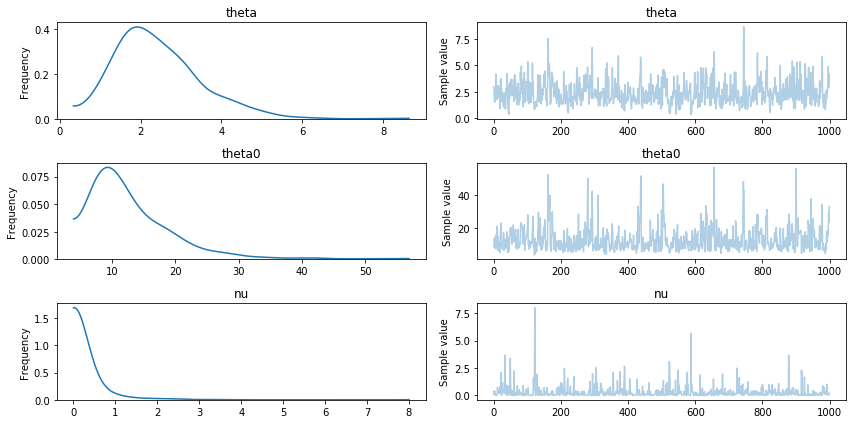

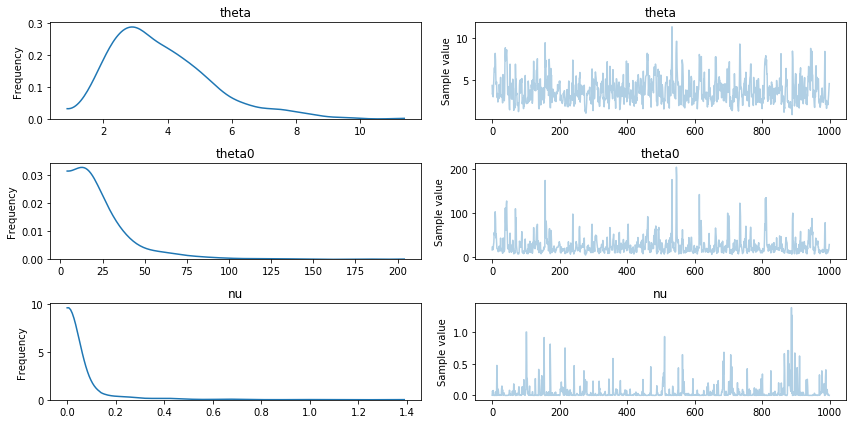

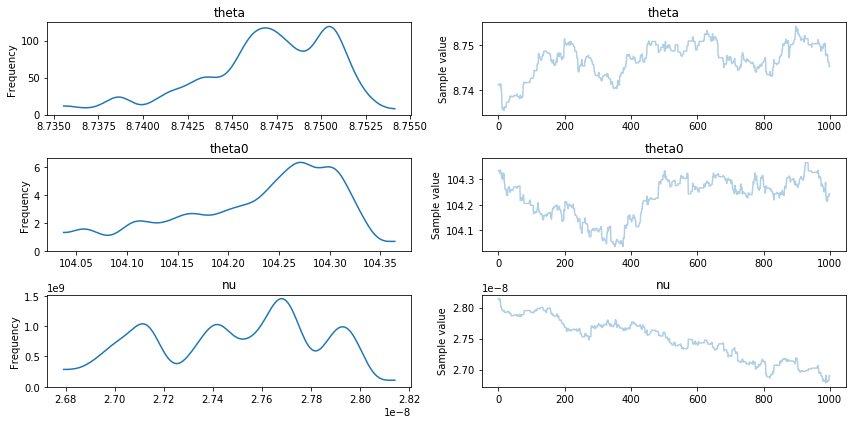

In [12]:
baye_1d_GP_MCMC_LCB = BayeOpt(target_func=g,x_range=g_range,init_points=3)
baye_1d_GP_MCMC_LCB.Iteration(mode = "MCMC",acquisition = "LCB",max_iter = 7)

***GP MCMC EI***


-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1} 



/Users/lechenqian/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


x y list: [[-5.        ]
 [-1.5       ]
 [ 2.        ]
 [-1.26533477]
 [-4.1254397 ]
 [-2.88684896]] [25.          2.25        4.          1.60107208 17.01925273  8.33389693]


Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:08<00:00, 179.37it/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


grad: [-5.19446953e-06]
x_next: [-0.72347216]


INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock


grad: [7.36286032e-06]
x_next: [-0.80309946]
grad: [2.90323321e-06]
x_next: [-1.00014677]
grad: [9.1565644e-06]
x_next: [-0.86333422]

x new: [-0.84751315]

y new: [0.71827855]

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1} 



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


x y list: [[-5.        ]
 [-1.5       ]
 [ 2.        ]
 [-1.26533477]
 [-4.1254397 ]
 [-2.88684896]
 [-0.84751315]] [25.          2.25        4.          1.60107208 17.01925273  8.33389693
  0.71827855]


Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:08<00:00, 173.73it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock


grad: [-6.72795153e-06]
x_next: [-0.69919613]
grad: [2.93355131e-13]
x_next: [-0.18756279]
grad: [2.5701663e-06]
x_next: [-0.74638338]
grad: [8.69269872e-42]
x_next: [-0.0761716]

x new: [-0.42732847]

y new: [0.18260962]

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1} 



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


x y list: [[-5.        ]
 [-1.5       ]
 [ 2.        ]
 [-1.26533477]
 [-4.1254397 ]
 [-2.88684896]
 [-0.84751315]
 [-0.42732847]] [25.          2.25        4.          1.60107208 17.01925273  8.33389693
  0.71827855  0.18260962]


Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:09<00:00, 160.91it/s]
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8853806054707183, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


grad: [0.]
x_next: [-0.00667372]
grad: [3.19258928e-81]
x_next: [-0.02612825]


INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock


grad: [0.]
x_next: [-0.14607851]
grad: [0.]
x_next: [-0.01452826]

x new: [-0.04835218]

y new: [0.00233793]

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1} 



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


x y list: [[-5.        ]
 [-1.5       ]
 [ 2.        ]
 [-1.26533477]
 [-4.1254397 ]
 [-2.88684896]
 [-0.84751315]
 [-0.42732847]
 [-0.04835218]] [2.50000000e+01 2.25000000e+00 4.00000000e+00 1.60107208e+00
 1.70192527e+01 8.33389693e+00 7.18278546e-01 1.82609623e-01
 2.33793379e-03]


Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [08:31<00:00,  1.96it/s]
There were 325 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8871666899051668, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock


grad: [0.25162735]
x_next: [0.05367602]


INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock


grad: [0.0410548]
x_next: [-0.0031756]


INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock


grad: [0.24674263]
x_next: [-0.03949882]


INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock


grad: [0.0022537]
x_next: [0.00970608]

x new: [0.00517692]

y new: [2.68004947e-05]


array([0.00517692])

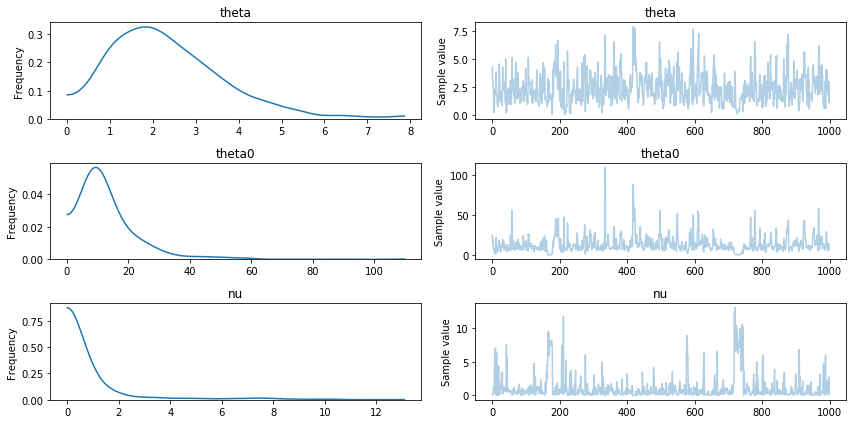

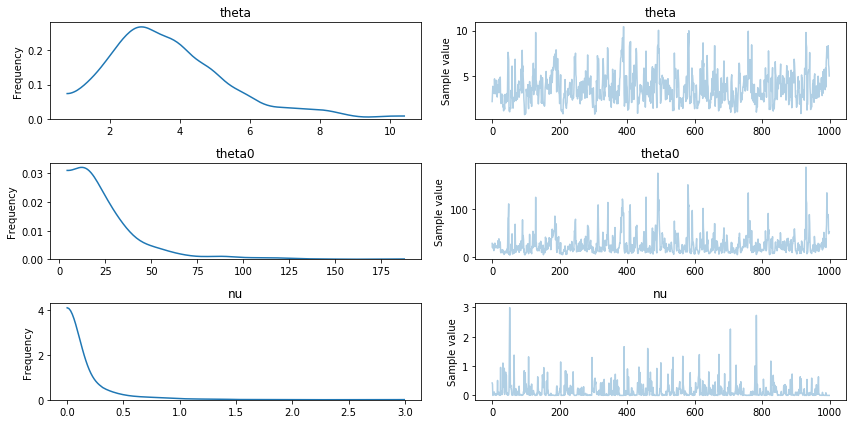

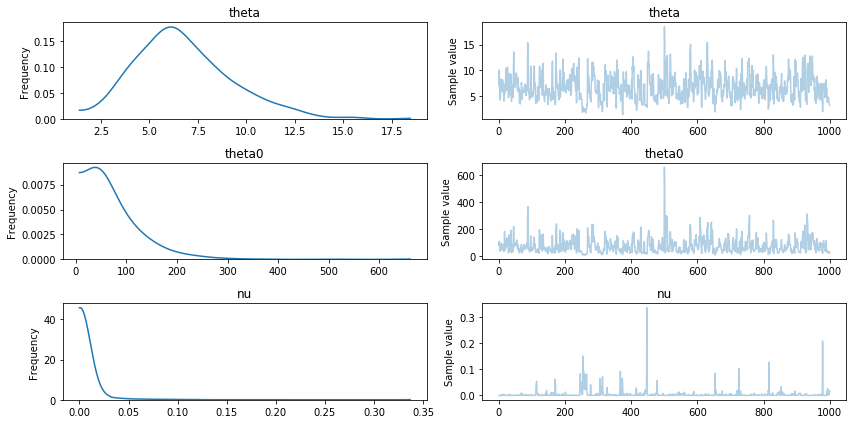

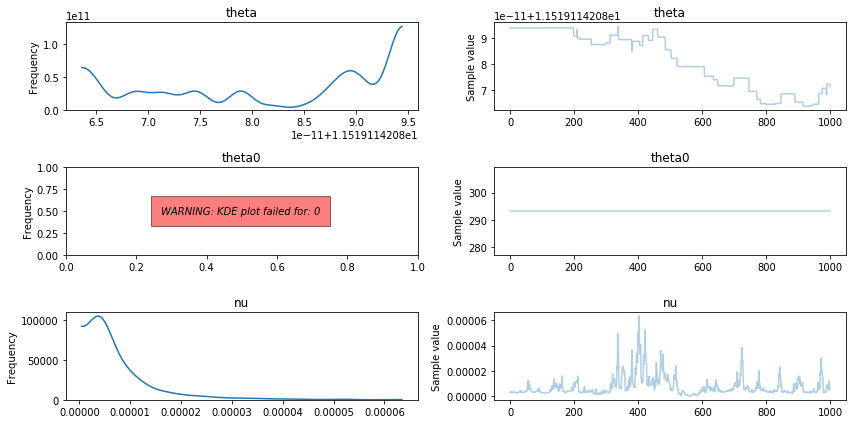

In [18]:
baye_1d_GP_MCMC_EI = BayeOpt(target_func=g,x_range=g_range,init_points=3)
baye_1d_GP_MCMC_EI.Iteration(mode = "MCMC",acquisition = "EI",max_iter = 7)

In the plot, the first 6 points along the iterations are actually initial points. The plots manifest the efficiency in training, as it only takes three to four real iterations to find a fairly small value of the target function.

Text(0.5,1,'Optimization of target function over iterations')

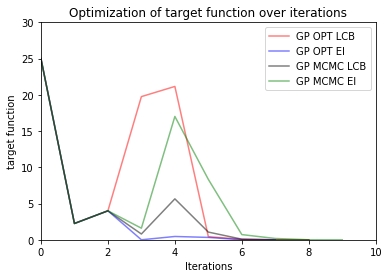

In [39]:
plt.xlim(0,10)
plt.ylim(0,30)
plt.xlabel("Iterations",fontsize=10)
plt.ylabel("target function",fontsize=10)
plt.plot(baye_1d_GP_OPT_LCB.y,c="r",alpha = 0.5)
plt.plot(baye_1d_GP_OPT_EI.y,c="b",alpha = 0.5)
plt.plot(baye_1d_GP_MCMC_LCB.y,c="k",alpha = 0.5)
plt.plot(baye_1d_GP_MCMC_EI.y,c="g", alpha = 0.5)
plt.legend(['GP OPT LCB','GP OPT EI','GP MCMC LCB','GP MCMC EI'])
plt.title('Optimization of target function over iterations')

---
From 1D example, we found tuning parameters by using GP OPT EI is the most efficient. For the following hyperparameter optimization, we'll keep using method GPOPT EI only, as the computing capability and resources of pc is limited.<br/>

---
2D example: We'll start GP with four initial points.

In [4]:
# give a simple function f(x,y) = x^2+y^2
f = lambda x:x[0]**2+x[1]**2
f_range = [[-5,-5],[3,3]]

In [26]:
baye_2d = BayeOpt(target_func=f,x_range=f_range,init_points=9)

In [27]:
baye_2d.Iteration(mode = "OPT",acquisition = "EI")

INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock



-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 



/Users/lechenqian/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [-0.58332216  1.03272654]
 [-3.23401251 -2.272747  ]
 [-2.25927877 -0.71320313]
 [-0.25766399  1.39409266]
 [-2.13843102  1.76754417]
 [-1.83045987 -0.68617975]
 [-4.0175041  -4.32935945]
 [-1.61423867  1.01037274]
 [-0.26410163  1.69769964]] [50.          2.         18.          1.40678886 15.62421582  5.61299924
  2.00988506  7.69709965  3.821426   34.88369249  3.62661957  2.95193374]


/Users/lechenqian/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/lechenqian/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/lechenqian/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the futu

MAP: {'theta_log__': array([0.73510206, 1.13591602]), 'theta0_log__': array(2.32409725), 'nu_log__': array(-2.91675688), 'theta': array([2.08569486, 3.11402475]), 'theta0': array(10.21745217), 'nu': array(0.05410888)}


INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock


grad: [-4.20168018e-06 -9.99750897e-06]
x_next: [-0.59582259  0.5031229 ]

x new: [-0.59582259  0.5031229 ]

y new: 0.6081372055488128

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [-0.58332216  1.03272654]
 [-3.23401251 -2.272747  ]
 [-2.25927877 -0.71320313]
 [-0.25766399  1.39409266]
 [-2.13843102  1.76754417]
 [-1.83045987 -0.68617975]
 [-4.0175041  -4.32935945]
 [-1.61423867  1.01037274]
 [-0.26410163  1.69769964]
 [-0.59582259  0.5031229 ]] [50.          2.         18.          1.40678886 15.62421582  5.61299924
  2.00988506  7.69709965  3.821426   34.88369249  3.62661957  2.95193374
  0.60813721]


logp = -48.675, ||grad|| = 0.80881: 100%|██████████| 33/33 [00:00<00:00, 684.89it/s]   


MAP: {'theta_log__': array([0.68371593, 1.22243007]), 'theta0_log__': array(2.33043228), 'nu_log__': array(-7.35801), 'theta': array([1.98122616, 3.39542884]), 'theta0': array(10.28238545), 'nu': array(0.00063747)}


INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock


grad: [ 8.00733081e-06 -2.96129779e-06]
x_next: [-0.53578957  0.16049622]

x new: [-0.53578957  0.16049622]

y new: 0.3128295050213979

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [-0.58332216  1.03272654]
 [-3.23401251 -2.272747  ]
 [-2.25927877 -0.71320313]
 [-0.25766399  1.39409266]
 [-2.13843102  1.76754417]
 [-1.83045987 -0.68617975]
 [-4.0175041  -4.32935945]
 [-1.61423867  1.01037274]
 [-0.26410163  1.69769964]
 [-0.59582259  0.5031229 ]
 [-0.53578957  0.16049622]] [50.          2.         18.          1.40678886 15.62421582  5.61299924
  2.00988506  7.69709965  3.821426   34.88369249  3.62661957  2.95193374
  0.60813721  0.31282951]


logp = -47.131, ||grad|| = 0.0095724: 100%|██████████| 38/38 [00:00<00:00, 507.59it/s]  


MAP: {'theta_log__': array([0.80338363, 1.22849939]), 'theta0_log__': array(2.3709784), 'nu_log__': array(-10.55047261), 'theta': array([2.23308409, 3.41609946]), 'theta0': array(10.70786375), 'nu': array(2.61811045e-05)}
grad: [ 8.05265176e-06 -5.88131507e-06]
x_next: [-0.07428963 -0.18899918]

x new: [-0.07428963 -0.18899918]

y new: 0.041239638338688926

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [-0.58332216  1.03272654]
 [-3.23401251 -2.272747  ]
 [-2.25927877 -0.71320313]
 [-0.25766399  1.39409266]
 [-2.13843102  1.76754417]
 [-1.83045987 -0.68617975]
 [-4.0175041  -4.32935945]
 [-1.61423867  1.01037274]
 [-0.26410163  1.69769964]
 [-0.59582259  0.5031229 ]
 [-0.53578957  0.16049622]
 [-0.07428963 -0.18899918]] [5.00000000e+01 2.00000000e+00 1.80000000e+01 1.40678886e+00
 1.56242158e+01 5.61299

logp = -47.351, ||grad|| = 0.10646: 100%|██████████| 26/26 [00:00<00:00, 782.29it/s]  
INFO (theano.gof.compilelock): Refreshing lock /Users/lechenqian/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.0-64/lock_dir/lock


MAP: {'theta_log__': array([0.72348291, 1.27013054]), 'theta0_log__': array(2.37001203), 'nu_log__': array(-4.87986443), 'theta': array([2.06160109, 3.56131743]), 'theta0': array(10.69752101), 'nu': array(0.00759804)}
grad: [-2.04845553e-05 -5.14048981e-06]
x_next: [-0.09311673 -0.1106148 ]

x new: [-0.09311673 -0.1106148 ]

y new: 0.02090635789940362


array([-0.09311673, -0.1106148 ])

Text(0.5,1,'Optimization of target function over iterations')

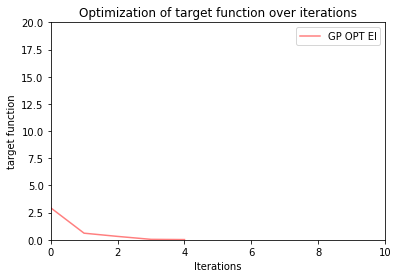

In [28]:
plt.xlim(0,10)
plt.ylim(0,20)
plt.xlabel("Iterations",fontsize=10)
plt.ylabel("target function",fontsize=10)
plt.plot(baye_2d.y[11:],c="r",alpha = 0.5)
plt.legend(['GP OPT EI'])
plt.title('Optimization of target function over iterations')

Regardless of the value output by inital points, we see a quick decrease in target function over interations.

In [61]:
y_his = np.zeros([5,30])
for i in range(5):
    baye_2d = BayeOpt(target_func=f,x_range=f_range,init_points=9)
    baye_2d.Iteration(mode = "OPT",acquisition = "EI")
    y_his[i,0:baye_2d.y.shape[0]] = baye_2d.y


-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 



/Users/lechenqian/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 2.94677246 -2.3635969 ]
 [-4.3124411   1.04546582]
 [ 1.15830147 -1.34496653]
 [-4.49203541  1.3007761 ]
 [-0.0937616   2.67514271]
 [-2.34567661 -0.92405136]
 [-2.68224845  1.3423507 ]
 [-2.46937517 -3.90229331]
 [-3.1914254   1.23986618]] [50.          2.         18.         14.27005827 19.69014701  3.15059726
 21.87040061  7.16517974  6.35606968  8.99636213 21.32570677 11.72246423]


logp = -55.242, ||grad|| = 0.033565: 100%|██████████| 47/47 [00:00<00:00, 548.12it/s]   


MAP: {'theta_log__': array([0.74761467, 0.86046376]), 'theta0_log__': array(2.23736014), 'nu_log__': array(-8.66778148), 'theta': array([2.1119563 , 2.36425688]), 'theta0': array(9.36856689), 'nu': array(0.00017204)}
grad: [ 6.21413596e-06 -3.69240641e-05]
x_next: [-0.9959874  -1.00025671]

x new: [-0.9959874  -1.00025671]

y new: 1.9925043806325855

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 2.94677246 -2.3635969 ]
 [-4.3124411   1.04546582]
 [ 1.15830147 -1.34496653]
 [-4.49203541  1.3007761 ]
 [-0.0937616   2.67514271]
 [-2.34567661 -0.92405136]
 [-2.68224845  1.3423507 ]
 [-2.46937517 -3.90229331]
 [-3.1914254   1.23986618]
 [-0.9959874  -1.00025671]] [50.          2.         18.         14.27005827 19.69014701  3.15059726
 21.87040061  7.16517974  6.35606968  8.99636213 21.32570677 11.72246423

logp = -50.542, ||grad|| = 0.0077476: 100%|██████████| 40/40 [00:00<00:00, 756.77it/s]  


MAP: {'theta_log__': array([0.91604084, 1.00757023]), 'theta0_log__': array(2.30225783), 'nu_log__': array(-12.73362745), 'theta': array([2.49937535, 2.73893792]), 'theta0': array(9.99672791), 'nu': array(2.95022993e-06)}
grad: [1.38510550e-07 7.53742484e-06]
x_next: [-0.77902732 -0.98776667]

x new: [-0.77902732 -0.98776667]

y new: 1.582566546776842

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 2.94677246 -2.3635969 ]
 [-4.3124411   1.04546582]
 [ 1.15830147 -1.34496653]
 [-4.49203541  1.3007761 ]
 [-0.0937616   2.67514271]
 [-2.34567661 -0.92405136]
 [-2.68224845  1.3423507 ]
 [-2.46937517 -3.90229331]
 [-3.1914254   1.23986618]
 [-0.9959874  -1.00025671]
 [-0.77902732 -0.98776667]] [50.          2.         18.         14.27005827 19.69014701  3.15059726
 21.87040061  7.16517974  6.35606968  8.996

logp = -49.052, ||grad|| = 0.001971: 100%|██████████| 47/47 [00:00<00:00, 628.55it/s]  


MAP: {'theta_log__': array([0.95074297, 1.09936775]), 'theta0_log__': array(2.33378716), 'nu_log__': array(-13.72801615), 'theta': array([2.58763148, 3.00226725]), 'theta0': array(10.31693951), 'nu': array(1.09143616e-06)}
grad: [2.69658841e-07 5.26870901e-06]
x_next: [-0.26920717 -0.9057633 ]

x new: [-0.26920717 -0.9057633 ]

y new: 0.8928796521405102

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 2.94677246 -2.3635969 ]
 [-4.3124411   1.04546582]
 [ 1.15830147 -1.34496653]
 [-4.49203541  1.3007761 ]
 [-0.0937616   2.67514271]
 [-2.34567661 -0.92405136]
 [-2.68224845  1.3423507 ]
 [-2.46937517 -3.90229331]
 [-3.1914254   1.23986618]
 [-0.9959874  -1.00025671]
 [-0.77902732 -0.98776667]
 [-0.26920717 -0.9057633 ]] [50.          2.         18.         14.27005827 19.69014701  3.15059726
 21.87040061  

logp = -47.284, ||grad|| = 0.00033489: 100%|██████████| 43/43 [00:00<00:00, 736.64it/s]  


MAP: {'theta_log__': array([1.02454823, 1.19492736]), 'theta0_log__': array(2.38382083), 'nu_log__': array(-16.40070975), 'theta': array([2.78583663, 3.3033178 ]), 'theta0': array(10.84626558), 'nu': array(7.5381063e-08)}
grad: [-1.30260661e-06  7.33394392e-06]
x_next: [-0.02436223 -0.39941105]

x new: [-0.02436223 -0.39941105]

y new: 0.1601227057114304

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 2.94677246 -2.3635969 ]
 [-4.3124411   1.04546582]
 [ 1.15830147 -1.34496653]
 [-4.49203541  1.3007761 ]
 [-0.0937616   2.67514271]
 [-2.34567661 -0.92405136]
 [-2.68224845  1.3423507 ]
 [-2.46937517 -3.90229331]
 [-3.1914254   1.23986618]
 [-0.9959874  -1.00025671]
 [-0.77902732 -0.98776667]
 [-0.26920717 -0.9057633 ]
 [-0.02436223 -0.39941105]] [50.          2.         18.         14.27005827 19.6901470

logp = -47.071, ||grad|| = 0.0010967: 100%|██████████| 87/87 [00:00<00:00, 709.24it/s]  


MAP: {'theta_log__': array([1.12364041, 1.2082519 ]), 'theta0_log__': array(2.454532), 'nu_log__': array(-16.91140833), 'theta': array([3.07603185, 3.34762754]), 'theta0': array(11.64098427), 'nu': array(4.52343841e-08)}
grad: [-2.43047369e-08  8.96979919e-06]
x_next: [-0.0320814  -0.10797051]

x new: [-0.0320814  -0.10797051]

y new: 0.012686848494723832

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 2.94677246 -2.3635969 ]
 [-4.3124411   1.04546582]
 [ 1.15830147 -1.34496653]
 [-4.49203541  1.3007761 ]
 [-0.0937616   2.67514271]
 [-2.34567661 -0.92405136]
 [-2.68224845  1.3423507 ]
 [-2.46937517 -3.90229331]
 [-3.1914254   1.23986618]
 [-0.9959874  -1.00025671]
 [-0.77902732 -0.98776667]
 [-0.26920717 -0.9057633 ]
 [-0.02436223 -0.39941105]
 [-0.0320814  -0.10797051]] [5.00000000e+01 2.00000000e+00 

logp = -45.168, ||grad|| = 0.011867: 100%|██████████| 87/87 [00:00<00:00, 664.88it/s]   


MAP: {'theta_log__': array([1.21406072, 1.25579296]), 'theta0_log__': array(2.52009372), 'nu_log__': array(-15.63245342), 'theta': array([3.36712991, 3.51062106]), 'theta0': array(12.42976152), 'nu': array(1.62521843e-07)}
grad: [-9.01674922e-06  5.74423674e-06]
x_next: [-0.04052495 -0.00607123]

x new: [-0.04052495 -0.00607123]

y new: 0.0016791315096449566

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 2.94677246 -2.3635969 ]
 [-4.3124411   1.04546582]
 [ 1.15830147 -1.34496653]
 [-4.49203541  1.3007761 ]
 [-0.0937616   2.67514271]
 [-2.34567661 -0.92405136]
 [-2.68224845  1.3423507 ]
 [-2.46937517 -3.90229331]
 [-3.1914254   1.23986618]
 [-0.9959874  -1.00025671]
 [-0.77902732 -0.98776667]
 [-0.26920717 -0.9057633 ]
 [-0.02436223 -0.39941105]
 [-0.0320814  -0.10797051]
 [-0.04052495 -0.00607123]] [

logp = -43.367, ||grad|| = 0.11336: 100%|██████████| 26/26 [00:00<00:00, 511.80it/s]  


MAP: {'theta_log__': array([1.21589626, 1.32161954]), 'theta0_log__': array(2.5697613), 'nu_log__': array(-7.29304847), 'theta': array([3.37331609, 3.7494889 ]), 'theta0': array(13.06270594), 'nu': array(0.00068025)}
grad: [0.00215532 0.00222896]
x_next: [-0.03928958 -0.01458162]

x new: [-0.03928958 -0.01458162]

y new: 0.0017562950565385312

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 2.94677246 -2.3635969 ]
 [-4.3124411   1.04546582]
 [ 1.15830147 -1.34496653]
 [-4.49203541  1.3007761 ]
 [-0.0937616   2.67514271]
 [-2.34567661 -0.92405136]
 [-2.68224845  1.3423507 ]
 [-2.46937517 -3.90229331]
 [-3.1914254   1.23986618]
 [-0.9959874  -1.00025671]
 [-0.77902732 -0.98776667]
 [-0.26920717 -0.9057633 ]
 [-0.02436223 -0.39941105]
 [-0.0320814  -0.10797051]
 [-0.04052495 -0.00607123]
 [-0.03928958 -0.0

logp = -33.422, ||grad|| = 0.0053375: 100%|██████████| 75/75 [00:00<00:00, 638.28it/s]  


MAP: {'theta_log__': array([1.25684209, 1.26242593]), 'theta0_log__': array(2.61159643), 'nu_log__': array(-15.77409632), 'theta': array([3.51430607, 3.5339843 ]), 'theta0': array(13.62077814), 'nu': array(1.41057769e-07)}
grad: [0.00170818 0.00177409]
x_next: [-0.0387521  -0.01318644]

x new: [-0.0387521  -0.01318644]

y new: 0.0016756074884322965

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 2.94677246 -2.3635969 ]
 [-4.3124411   1.04546582]
 [ 1.15830147 -1.34496653]
 [-4.49203541  1.3007761 ]
 [-0.0937616   2.67514271]
 [-2.34567661 -0.92405136]
 [-2.68224845  1.3423507 ]
 [-2.46937517 -3.90229331]
 [-3.1914254   1.23986618]
 [-0.9959874  -1.00025671]
 [-0.77902732 -0.98776667]
 [-0.26920717 -0.9057633 ]
 [-0.02436223 -0.39941105]
 [-0.0320814  -0.10797051]
 [-0.04052495 -0.00607123]
 [-0.0392895

logp = -21.788, ||grad|| = 0.41707: 100%|██████████| 46/46 [00:00<00:00, 644.81it/s]  


MAP: {'theta_log__': array([1.3319859 , 1.33075825]), 'theta0_log__': array(2.68662289), 'nu_log__': array(-16.5220204), 'theta': array([3.78855962, 3.78391146]), 'theta0': array(14.68200932), 'nu': array(6.67694361e-08)}
grad: [0.00559342 0.00159881]
x_next: [-0.03811274 -0.01152439]

x new: [-0.03811274 -0.01152439]

y new: 0.0015853923202356257

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 2.94677246 -2.3635969 ]
 [-4.3124411   1.04546582]
 [ 1.15830147 -1.34496653]
 [-4.49203541  1.3007761 ]
 [-0.0937616   2.67514271]
 [-2.34567661 -0.92405136]
 [-2.68224845  1.3423507 ]
 [-2.46937517 -3.90229331]
 [-3.1914254   1.23986618]
 [-0.9959874  -1.00025671]
 [-0.77902732 -0.98776667]
 [-0.26920717 -0.9057633 ]
 [-0.02436223 -0.39941105]
 [-0.0320814  -0.10797051]
 [-0.04052495 -0.00607123]
 [-0.03928958

logp = -63.46, ||grad|| = 20.534: 100%|██████████| 21/21 [00:00<00:00, 470.90it/s]  


MAP: {'theta_log__': array([1.28165325, 1.29769547]), 'theta0_log__': array(2.7287762), 'nu_log__': array(-20.62891737), 'theta': array([3.60259078, 3.66085038]), 'theta0': array(15.31413407), 'nu': array(1.09894263e-09)}
grad: [ 0.00386113 -0.00064764]
x_next: [-0.0382005  -0.01203905]

x new: [-0.0382005  -0.01203905]

y new: 0.0016042169216725134

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [-0.60678073  0.7720805 ]
 [-4.58940523  0.96137102]
 [-3.98076435  0.29927237]
 [-3.76261924  2.69880948]
 [-3.97030291 -2.29749697]
 [-2.3307012  -1.50252699]
 [-4.41517848 -1.49282397]
 [-3.69797722 -4.42432653]
 [-3.91413724  1.0373421 ]] [50.          2.         18.          0.96429115 21.98687459 15.93604874
 21.44087613 21.04179756  7.68975546 21.72232445 33.24970077 16.39654894]


logp = -53.992, ||grad|| = 0.0014743: 100%|██████████| 40/40 [00:00<00:00, 721.27it/s]  


MAP: {'theta_log__': array([0.48359751, 0.85063936]), 'theta0_log__': array(2.19995928), 'nu_log__': array(-8.29707575), 'theta': array([1.62189871, 2.34114321]), 'theta0': array(9.02464599), 'nu': array(0.00024924)}
grad: [-0.00282822  0.00022136]
x_next: [-0.6069258   0.77132046]

x new: [-0.6069258   0.77132046]

y new: 0.9632941768986905

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [-0.60678073  0.7720805 ]
 [-4.58940523  0.96137102]
 [-3.98076435  0.29927237]
 [-3.76261924  2.69880948]
 [-3.97030291 -2.29749697]
 [-2.3307012  -1.50252699]
 [-4.41517848 -1.49282397]
 [-3.69797722 -4.42432653]
 [-3.91413724  1.0373421 ]
 [-0.6069258   0.77132046]] [50.          2.         18.          0.96429115 21.98687459 15.93604874
 21.44087613 21.04179756  7.68975546 21.72232445 33.24970077 16.39654894
  0.963

logp = -48.841, ||grad|| = 0.00017132: 100%|██████████| 26/26 [00:00<00:00, 457.96it/s]  


MAP: {'theta_log__': array([0.49120794, 0.91156867]), 'theta0_log__': array(2.21561891), 'nu_log__': array(-21.50013451), 'theta': array([1.63428915, 2.48822267]), 'theta0': array(9.16708091), 'nu': array(4.5984368e-10)}
grad: [0.0002058  0.00016933]
x_next: [-0.60707675  0.77045231]

x new: [-0.60707675  0.77045231]

y new: 0.9621389431630658

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [-4.15867678  1.22835171]
 [-4.81968758  1.53176284]
 [-4.85978437 -1.77278803]
 [ 0.06661825  1.5137088 ]
 [-2.53559397 -4.15740293]
 [ 0.04871815 -4.05665717]
 [-1.31658239 -2.61102031]
 [ 0.23747685 -0.38486122]
 [ 0.48923864 -2.0024452 ]] [50.          2.         18.         18.8034405  25.57568575 26.76028154
  2.29575232 23.71323586 16.45884086  8.55081625  0.20451342  4.24914121]


logp = -57.814, ||grad|| = 7.1974e-05: 100%|██████████| 44/44 [00:00<00:00, 423.34it/s]  


MAP: {'theta_log__': array([0.5424818 , 0.87890685]), 'theta0_log__': array(2.23361089), 'nu_log__': array(-7.68523982), 'theta': array([1.72027094, 2.40826568]), 'theta0': array(9.33350754), 'nu': array(0.00045956)}
grad: [0.00090984 0.00022931]
x_next: [ 0.23707577 -0.38366622]

x new: [ 0.23707577 -0.38366622]

y new: 0.20340468616663573

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [-4.15867678  1.22835171]
 [-4.81968758  1.53176284]
 [-4.85978437 -1.77278803]
 [ 0.06661825  1.5137088 ]
 [-2.53559397 -4.15740293]
 [ 0.04871815 -4.05665717]
 [-1.31658239 -2.61102031]
 [ 0.23747685 -0.38486122]
 [ 0.48923864 -2.0024452 ]
 [ 0.23707577 -0.38366622]] [50.          2.         18.         18.8034405  25.57568575 26.76028154
  2.29575232 23.71323586 16.45884086  8.55081625  0.20451342  4.24914121
  0.2034

logp = -52.208, ||grad|| = 0.00052986: 100%|██████████| 45/45 [00:00<00:00, 687.11it/s]  


MAP: {'theta_log__': array([0.59265644, 0.97009776]), 'theta0_log__': array(2.25776821), 'nu_log__': array(-15.07690429), 'theta': array([1.80878696, 2.63820234]), 'theta0': array(9.56172562), 'nu': array(2.83258964e-07)}
grad: [0.00123103 0.00063142]
x_next: [ 0.23649257 -0.38133515]

x new: [ 0.23649257 -0.38133515]

y new: 0.20134523136472157

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [-4.15867678  1.22835171]
 [-4.81968758  1.53176284]
 [-4.85978437 -1.77278803]
 [ 0.06661825  1.5137088 ]
 [-2.53559397 -4.15740293]
 [ 0.04871815 -4.05665717]
 [-1.31658239 -2.61102031]
 [ 0.23747685 -0.38486122]
 [ 0.48923864 -2.0024452 ]
 [ 0.23707577 -0.38366622]
 [ 0.23649257 -0.38133515]] [50.          2.         18.         18.8034405  25.57568575 26.76028154
  2.29575232 23.71323586 16.45884086  8.55081625 

logp = -45.511, ||grad|| = 0.00063699: 100%|██████████| 92/92 [00:00<00:00, 660.23it/s]  


MAP: {'theta_log__': array([0.721254  , 1.01591213]), 'theta0_log__': array(2.29268567), 'nu_log__': array(-16.81224874), 'theta': array([2.0570111 , 2.76188143]), 'theta0': array(9.90149414), 'nu': array(4.994973e-08)}
grad: [0.00017685 0.00010034]
x_next: [ 0.23328537 -0.36856599]

x new: [ 0.23328537 -0.36856599]

y new: 0.19026295166339047

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [-4.15867678  1.22835171]
 [-4.81968758  1.53176284]
 [-4.85978437 -1.77278803]
 [ 0.06661825  1.5137088 ]
 [-2.53559397 -4.15740293]
 [ 0.04871815 -4.05665717]
 [-1.31658239 -2.61102031]
 [ 0.23747685 -0.38486122]
 [ 0.48923864 -2.0024452 ]
 [ 0.23707577 -0.38366622]
 [ 0.23649257 -0.38133515]
 [ 0.23328537 -0.36856599]] [50.          2.         18.         18.8034405  25.57568575 26.76028154
  2.29575232 23.71323586

logp = -inf, ||grad|| = 0: 100%|██████████| 22/22 [00:00<00:00, 655.39it/s]          


MAP: {'theta_log__': array([3.41259834, 1.82300604]), 'theta0_log__': array(2.01421286), 'nu_log__': array(-18.68203127), 'theta': array([30.34398585,  6.19043924]), 'theta0': array(7.49482557), 'nu': array(7.70010961e-09)}
grad: [0. 0.]
x_next: [-0.015478    0.02187522]

x new: [-0.015478    0.02187522]

y new: 0.0007180937340842822

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [-4.15867678  1.22835171]
 [-4.81968758  1.53176284]
 [-4.85978437 -1.77278803]
 [ 0.06661825  1.5137088 ]
 [-2.53559397 -4.15740293]
 [ 0.04871815 -4.05665717]
 [-1.31658239 -2.61102031]
 [ 0.23747685 -0.38486122]
 [ 0.48923864 -2.0024452 ]
 [ 0.23707577 -0.38366622]
 [ 0.23649257 -0.38133515]
 [ 0.23328537 -0.36856599]
 [-0.015478    0.02187522]] [5.00000000e+01 2.00000000e+00 1.80000000e+01 1.88034405e+01
 2.55756858e+01 2.6

logp = -34.156, ||grad|| = 0.05424: 100%|██████████| 74/74 [00:00<00:00, 840.43it/s]  


MAP: {'theta_log__': array([0.83153293, 1.19095673]), 'theta0_log__': array(2.38185139), 'nu_log__': array(-16.15405624), 'theta': array([2.29683693, 3.29022755]), 'theta0': array(10.82492543), 'nu': array(9.64678316e-08)}
grad: [0.00122786 0.00100476]
x_next: [-0.01482485  0.02226889]

x new: [-0.01482485  0.02226889]

y new: 0.0007156797380694651

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 0.11679683  2.12361916]
 [-1.37602545 -0.31869127]
 [-1.6046903  -0.22716465]
 [ 2.9224098  -1.22625801]
 [ 2.94681761  0.95527941]
 [-3.3282104  -2.19011123]
 [-2.43374625 -1.87811408]
 [-0.42786194 -1.35254897]
 [-4.77855113  0.10420954]] [50.          2.         18.          4.52339983  1.99501016  2.62663474
 10.04418777  9.59629278 15.87357165  9.45043332  2.01245455 22.84541057]


logp = -53.898, ||grad|| = 0.0058531: 100%|██████████| 40/40 [00:00<00:00, 657.55it/s]  


MAP: {'theta_log__': array([0.9691197, 0.7096905]), 'theta0_log__': array(2.28776557), 'nu_log__': array(-9.2054436), 'theta': array([2.63562329, 2.03336184]), 'theta0': array(9.85289747), 'nu': array(0.00010049)}
grad: [ 5.00490898e-06 -1.05650524e-06]
x_next: [-0.76948597 -0.35717514]

x new: [-0.76948597 -0.35717514]

y new: 0.7196827430931196

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 0.11679683  2.12361916]
 [-1.37602545 -0.31869127]
 [-1.6046903  -0.22716465]
 [ 2.9224098  -1.22625801]
 [ 2.94681761  0.95527941]
 [-3.3282104  -2.19011123]
 [-2.43374625 -1.87811408]
 [-0.42786194 -1.35254897]
 [-4.77855113  0.10420954]
 [-0.76948597 -0.35717514]] [50.          2.         18.          4.52339983  1.99501016  2.62663474
 10.04418777  9.59629278 15.87357165  9.45043332  2.01245455 22.84541057
  

logp = -54.009, ||grad|| = 0.03612: 100%|██████████| 27/27 [00:00<00:00, 696.99it/s]  


MAP: {'theta_log__': array([1.11798247, 0.76098809]), 'theta0_log__': array(2.33678722), 'nu_log__': array(-3.88478582), 'theta': array([3.058677  , 2.14039008]), 'theta0': array(10.34793741), 'nu': array(0.02055223)}
grad: [8.07407569e-06 2.36875791e-06]
x_next: [-0.34629891 -0.09455047]

x new: [-0.34629891 -0.09455047]

y new: 0.1288627255833521

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 0.11679683  2.12361916]
 [-1.37602545 -0.31869127]
 [-1.6046903  -0.22716465]
 [ 2.9224098  -1.22625801]
 [ 2.94681761  0.95527941]
 [-3.3282104  -2.19011123]
 [-2.43374625 -1.87811408]
 [-0.42786194 -1.35254897]
 [-4.77855113  0.10420954]
 [-0.76948597 -0.35717514]
 [-0.34629891 -0.09455047]] [50.          2.         18.          4.52339983  1.99501016  2.62663474
 10.04418777  9.59629278 15.87357165  9.450433

logp = -53.107, ||grad|| = 0.094154: 100%|██████████| 30/30 [00:00<00:00, 515.74it/s]  


MAP: {'theta_log__': array([1.22107144, 0.81930552]), 'theta0_log__': array(2.38598875), 'nu_log__': array(-4.98246271), 'theta': array([3.39081884, 2.26892356]), 'theta0': array(10.8698049), 'nu': array(0.00685715)}
grad: [5.7360330e-06 8.1597905e-06]
x_next: [-0.14953976  0.07025045]

x new: [-0.14953976  0.07025045]

y new: 0.02729726577302435

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 0.11679683  2.12361916]
 [-1.37602545 -0.31869127]
 [-1.6046903  -0.22716465]
 [ 2.9224098  -1.22625801]
 [ 2.94681761  0.95527941]
 [-3.3282104  -2.19011123]
 [-2.43374625 -1.87811408]
 [-0.42786194 -1.35254897]
 [-4.77855113  0.10420954]
 [-0.76948597 -0.35717514]
 [-0.34629891 -0.09455047]
 [-0.14953976  0.07025045]] [5.00000000e+01 2.00000000e+00 1.80000000e+01 4.52339983e+00
 1.99501016e+00 2.62663474e+00 1.

logp = -50.382, ||grad|| = 4.3668e-05: 100%|██████████| 66/66 [00:00<00:00, 773.10it/s]  


MAP: {'theta_log__': array([1.37671649, 0.83622535]), 'theta0_log__': array(2.45260202), 'nu_log__': array(-6.25827367), 'theta': array([3.96187142, 2.30763998]), 'theta0': array(11.61853914), 'nu': array(0.00191455)}
grad: [-9.02592508e-05 -5.07671060e-05]
x_next: [-0.12700494  0.10369734]

x new: [-0.12700494  0.10369734]

y new: 0.026883394438020014

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 0.11679683  2.12361916]
 [-1.37602545 -0.31869127]
 [-1.6046903  -0.22716465]
 [ 2.9224098  -1.22625801]
 [ 2.94681761  0.95527941]
 [-3.3282104  -2.19011123]
 [-2.43374625 -1.87811408]
 [-0.42786194 -1.35254897]
 [-4.77855113  0.10420954]
 [-0.76948597 -0.35717514]
 [-0.34629891 -0.09455047]
 [-0.14953976  0.07025045]
 [-0.12700494  0.10369734]] [5.00000000e+01 2.00000000e+00 1.80000000e+01 4.52339983e+00


logp = -46.896, ||grad|| = 6.7353e-05: 100%|██████████| 22/22 [00:00<00:00, 647.25it/s]  


MAP: {'theta_log__': array([1.22317918, 1.01577625]), 'theta0_log__': array(2.47706057), 'nu_log__': array(-6.05863849), 'theta': array([3.39797334, 2.7615062 ]), 'theta0': array(11.90621549), 'nu': array(0.00233758)}
grad: [0.000214   0.00058161]
x_next: [-0.12144972  0.10151408]

x new: [-0.12144972  0.10151408]

y new: 0.025055142810911632

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 0.11679683  2.12361916]
 [-1.37602545 -0.31869127]
 [-1.6046903  -0.22716465]
 [ 2.9224098  -1.22625801]
 [ 2.94681761  0.95527941]
 [-3.3282104  -2.19011123]
 [-2.43374625 -1.87811408]
 [-0.42786194 -1.35254897]
 [-4.77855113  0.10420954]
 [-0.76948597 -0.35717514]
 [-0.34629891 -0.09455047]
 [-0.14953976  0.07025045]
 [-0.12700494  0.10369734]
 [-0.12144972  0.10151408]] [5.00000000e+01 2.00000000e+00 1.80000000e+0

logp = -38.891, ||grad|| = 0.0017849: 100%|██████████| 99/99 [00:00<00:00, 425.44it/s]   


MAP: {'theta_log__': array([1.09506613, 1.15390227]), 'theta0_log__': array(2.50242761), 'nu_log__': array(-15.53936902), 'theta': array([2.98938037, 3.1705411 ]), 'theta0': array(12.21210425), 'nu': array(1.78376559e-07)}
grad: [0.00052183 0.00051329]
x_next: [-0.10841014  0.10213416]

x new: [-0.10841014  0.10213416]

y new: 0.02218414396754683

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 0.11679683  2.12361916]
 [-1.37602545 -0.31869127]
 [-1.6046903  -0.22716465]
 [ 2.9224098  -1.22625801]
 [ 2.94681761  0.95527941]
 [-3.3282104  -2.19011123]
 [-2.43374625 -1.87811408]
 [-0.42786194 -1.35254897]
 [-4.77855113  0.10420954]
 [-0.76948597 -0.35717514]
 [-0.34629891 -0.09455047]
 [-0.14953976  0.07025045]
 [-0.12700494  0.10369734]
 [-0.12144972  0.10151408]
 [-0.10841014  0.10213416]] [5.00000000e+

logp = -29.48, ||grad|| = 0.12556: 100%|██████████| 87/87 [00:00<00:00, 685.22it/s]    


MAP: {'theta_log__': array([1.17726662, 1.13631382]), 'theta0_log__': array(2.53962136), 'nu_log__': array(-16.65070012), 'theta': array([3.24549091, 3.11526375]), 'theta0': array(12.67487087), 'nu': array(5.8707396e-08)}
grad: [ 9.69355350e-05 -7.05430811e-05]
x_next: [-0.08903526  0.08325609]

x new: [-0.08903526  0.08325609]

y new: 0.014858854568163445

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 0.11679683  2.12361916]
 [-1.37602545 -0.31869127]
 [-1.6046903  -0.22716465]
 [ 2.9224098  -1.22625801]
 [ 2.94681761  0.95527941]
 [-3.3282104  -2.19011123]
 [-2.43374625 -1.87811408]
 [-0.42786194 -1.35254897]
 [-4.77855113  0.10420954]
 [-0.76948597 -0.35717514]
 [-0.34629891 -0.09455047]
 [-0.14953976  0.07025045]
 [-0.12700494  0.10369734]
 [-0.12144972  0.10151408]
 [-0.10841014  0.10213416]
 [-0

logp = -19.823, ||grad|| = 0.89635: 100%|██████████| 47/47 [00:00<00:00, 677.33it/s]  


MAP: {'theta_log__': array([1.63328283, 1.62021319]), 'theta0_log__': array(1.73925139), 'nu_log__': array(-16.997861), 'theta': array([5.12065739, 5.05416771]), 'theta0': array(5.69307992), 'nu': array(4.14880251e-08)}
grad: [ 1.31764804e-08 -2.03060997e-08]
x_next: [-0.01298955 -0.00194871]

x new: [-0.01298955 -0.00194871]

y new: 0.00017252593282199535

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.00000000e+00 -5.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00]
 [ 3.00000000e+00  3.00000000e+00]
 [ 1.16796829e-01  2.12361916e+00]
 [-1.37602545e+00 -3.18691265e-01]
 [-1.60469030e+00 -2.27164647e-01]
 [ 2.92240980e+00 -1.22625801e+00]
 [ 2.94681761e+00  9.55279411e-01]
 [-3.32821040e+00 -2.19011123e+00]
 [-2.43374625e+00 -1.87811408e+00]
 [-4.27861940e-01 -1.35254897e+00]
 [-4.77855113e+00  1.04209535e-01]
 [-7.69485971e-01 -3.57175144e-01]
 [-3.46298908e-01 -9.45504733e-02]


logp = -12.605, ||grad|| = 2.994: 100%|██████████| 29/29 [00:00<00:00, 521.30it/s]   


MAP: {'theta_log__': array([1.44230739, 1.44489044]), 'theta0_log__': array(2.93826207), 'nu_log__': array(-16.9819039), 'theta': array([4.23044586, 4.24138742]), 'theta0': array(18.8830005), 'nu': array(4.21553642e-08)}
grad: [0.00228525 0.00221368]
x_next: [-0.00962635 -0.00495197]

x new: [-0.00962635 -0.00495197]

y new: 0.00011718856323632188

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.00000000e+00 -5.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00]
 [ 3.00000000e+00  3.00000000e+00]
 [ 1.16796829e-01  2.12361916e+00]
 [-1.37602545e+00 -3.18691265e-01]
 [-1.60469030e+00 -2.27164647e-01]
 [ 2.92240980e+00 -1.22625801e+00]
 [ 2.94681761e+00  9.55279411e-01]
 [-3.32821040e+00 -2.19011123e+00]
 [-2.43374625e+00 -1.87811408e+00]
 [-4.27861940e-01 -1.35254897e+00]
 [-4.77855113e+00  1.04209535e-01]
 [-7.69485971e-01 -3.57175144e-01]
 [-3.46298908e-01 -9.45504733e-02]
 [-1.4953

logp = -56.899, ||grad|| = 26.66: 100%|██████████| 15/15 [00:00<00:00, 351.36it/s]  


MAP: {'theta_log__': array([1.41646017, 1.18287958]), 'theta0_log__': array(2.90419052), 'nu_log__': array(-15.775615), 'theta': array([4.12250163, 3.26375893]), 'theta0': array(18.25046436), 'nu': array(1.4084371e-07)}
grad: [-0.00117452  0.00604821]
x_next: [-0.00353767  0.00138946]

x new: [-0.00353767  0.00138946]

y new: 1.444570063575491e-05

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 0.73155167 -3.93782197]
 [ 2.34502218 -1.55642852]
 [ 2.52470004 -0.92030971]
 [-3.69599377  1.97422215]
 [-4.46869955 -0.77368762]
 [-2.06473788 -1.13894837]
 [-4.73757625  0.01186248]
 [ 2.17871316 -1.02580664]
 [-2.81674068 -3.84189509]] [50.          2.         18.         16.0416097   7.92159875  7.22108027
 17.55792309 20.56786817  5.56034589 22.44476947  5.79907029 22.694186  ]


logp = -54.659, ||grad|| = 0.0001393: 100%|██████████| 44/44 [00:00<00:00, 602.96it/s]  


MAP: {'theta_log__': array([0.75186905, 0.60131873]), 'theta0_log__': array(2.1717493), 'nu_log__': array(-7.77431322), 'theta': array([2.12096049, 1.82452327]), 'theta0': array(8.77361832), 'nu': array(0.0004204)}
grad: [-0.00044886  0.00018199]
x_next: [-0.9967147  -0.99968358]

x new: [-0.9967147  -0.99968358]

y new: 1.9928074562614233

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 0.73155167 -3.93782197]
 [ 2.34502218 -1.55642852]
 [ 2.52470004 -0.92030971]
 [-3.69599377  1.97422215]
 [-4.46869955 -0.77368762]
 [-2.06473788 -1.13894837]
 [-4.73757625  0.01186248]
 [ 2.17871316 -1.02580664]
 [-2.81674068 -3.84189509]
 [-0.9967147  -0.99968358]] [50.          2.         18.         16.0416097   7.92159875  7.22108027
 17.55792309 20.56786817  5.56034589 22.44476947  5.79907029 22.694186
  1.9928074

logp = -49.338, ||grad|| = 0.0080603: 100%|██████████| 41/41 [00:00<00:00, 558.13it/s]  


MAP: {'theta_log__': array([0.98855263, 0.70419353]), 'theta0_log__': array(2.23201898), 'nu_log__': array(-14.21528043), 'theta': array([2.68734207, 2.02221517]), 'theta0': array(9.31866125), 'nu': array(6.70474322e-07)}
grad: [-1.23340987e-07 -5.72034235e-06]
x_next: [-0.9365389  -1.00161818]

x new: [-0.9365389  -1.00161818]

y new: 1.8803440877631052

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 0.73155167 -3.93782197]
 [ 2.34502218 -1.55642852]
 [ 2.52470004 -0.92030971]
 [-3.69599377  1.97422215]
 [-4.46869955 -0.77368762]
 [-2.06473788 -1.13894837]
 [-4.73757625  0.01186248]
 [ 2.17871316 -1.02580664]
 [-2.81674068 -3.84189509]
 [-0.9967147  -0.99968358]
 [-0.9365389  -1.00161818]] [50.          2.         18.         16.0416097   7.92159875  7.22108027
 17.55792309 20.56786817  5.56034589 22.

logp = -47.316, ||grad|| = 0.0092038: 100%|██████████| 39/39 [00:00<00:00, 842.95it/s]  


MAP: {'theta_log__': array([0.93406003, 0.87452755]), 'theta0_log__': array(2.25309902), 'nu_log__': array(-14.96286381), 'theta': array([2.54482029, 2.3977422 ]), 'theta0': array(9.51718412), 'nu': array(3.17475937e-07)}
grad: [3.45733303e-07 6.11325189e-06]
x_next: [-0.25459419 -0.94524822]

x new: [-0.25459419 -0.94524822]

y new: 0.9583124030600478

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 0.73155167 -3.93782197]
 [ 2.34502218 -1.55642852]
 [ 2.52470004 -0.92030971]
 [-3.69599377  1.97422215]
 [-4.46869955 -0.77368762]
 [-2.06473788 -1.13894837]
 [-4.73757625  0.01186248]
 [ 2.17871316 -1.02580664]
 [-2.81674068 -3.84189509]
 [-0.9967147  -0.99968358]
 [-0.9365389  -1.00161818]
 [-0.25459419 -0.94524822]] [50.          2.         18.         16.0416097   7.92159875  7.22108027
 17.55792309 20

logp = -45.44, ||grad|| = 0.0042988: 100%|██████████| 78/78 [00:00<00:00, 697.49it/s]  


MAP: {'theta_log__': array([1.07389502, 0.89620348]), 'theta0_log__': array(2.32605506), 'nu_log__': array(-15.86133747), 'theta': array([2.9267571 , 2.45028289]), 'theta0': array(10.23747552), 'nu': array(1.29273248e-07)}
grad: [-1.68454188e-06  9.38473612e-06]
x_next: [-0.11967428 -0.79797165]

x new: [-0.11967428 -0.79797165]

y new: 0.6510806862391879

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 0.73155167 -3.93782197]
 [ 2.34502218 -1.55642852]
 [ 2.52470004 -0.92030971]
 [-3.69599377  1.97422215]
 [-4.46869955 -0.77368762]
 [-2.06473788 -1.13894837]
 [-4.73757625  0.01186248]
 [ 2.17871316 -1.02580664]
 [-2.81674068 -3.84189509]
 [-0.9967147  -0.99968358]
 [-0.9365389  -1.00161818]
 [-0.25459419 -0.94524822]
 [-0.11967428 -0.79797165]] [50.          2.         18.         16.0416097   7.921598

logp = -44.387, ||grad|| = 0.00012827: 100%|██████████| 43/43 [00:00<00:00, 688.12it/s]  


MAP: {'theta_log__': array([1.14565886, 0.92939841]), 'theta0_log__': array(2.37819727), 'nu_log__': array(-16.53432105), 'theta': array([3.14451247, 2.5329849 ]), 'theta0': array(10.7854421), 'nu': array(6.59531598e-08)}
grad: [-2.22452454e-06  6.93808337e-06]
x_next: [-0.10277209 -0.54772237]

x new: [-0.10277209 -0.54772237]

y new: 0.31056190140004003

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 0.73155167 -3.93782197]
 [ 2.34502218 -1.55642852]
 [ 2.52470004 -0.92030971]
 [-3.69599377  1.97422215]
 [-4.46869955 -0.77368762]
 [-2.06473788 -1.13894837]
 [-4.73757625  0.01186248]
 [ 2.17871316 -1.02580664]
 [-2.81674068 -3.84189509]
 [-0.9967147  -0.99968358]
 [-0.9365389  -1.00161818]
 [-0.25459419 -0.94524822]
 [-0.11967428 -0.79797165]
 [-0.10277209 -0.54772237]] [50.          2.         18.   

logp = -43.789, ||grad|| = 0.095758: 100%|██████████| 25/25 [00:00<00:00, 175.46it/s] 


MAP: {'theta_log__': array([1.13385485, 1.12106594]), 'theta0_log__': array(2.44689227), 'nu_log__': array(-9.99134638), 'theta': array([3.10761283, 3.06812291]), 'theta0': array(11.55238919), 'nu': array(4.57945084e-05)}
grad: [4.48733015e-53 4.62732164e-53]
x_next: [-0.08257521 -0.21362846]

x new: [-0.08257521 -0.21362846]

y new: 0.05245578568249182

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 0.73155167 -3.93782197]
 [ 2.34502218 -1.55642852]
 [ 2.52470004 -0.92030971]
 [-3.69599377  1.97422215]
 [-4.46869955 -0.77368762]
 [-2.06473788 -1.13894837]
 [-4.73757625  0.01186248]
 [ 2.17871316 -1.02580664]
 [-2.81674068 -3.84189509]
 [-0.9967147  -0.99968358]
 [-0.9365389  -1.00161818]
 [-0.25459419 -0.94524822]
 [-0.11967428 -0.79797165]
 [-0.10277209 -0.54772237]
 [-0.08257521 -0.21362846]] [50.  

logp = -40.969, ||grad|| = 0.0018948: 100%|██████████| 99/99 [00:00<00:00, 688.17it/s]  


MAP: {'theta_log__': array([1.1505241 , 1.16122122]), 'theta0_log__': array(2.49300855), 'nu_log__': array(-15.521574), 'theta': array([3.15984856, 3.19383126]), 'theta0': array(12.09761774), 'nu': array(1.81579185e-07)}
grad: [ 5.19500738e-06 -1.02664102e-06]
x_next: [-0.03260131 -0.10016077]

x new: [-0.03260131 -0.10016077]

y new: 0.011095024955049566

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 0.73155167 -3.93782197]
 [ 2.34502218 -1.55642852]
 [ 2.52470004 -0.92030971]
 [-3.69599377  1.97422215]
 [-4.46869955 -0.77368762]
 [-2.06473788 -1.13894837]
 [-4.73757625  0.01186248]
 [ 2.17871316 -1.02580664]
 [-2.81674068 -3.84189509]
 [-0.9967147  -0.99968358]
 [-0.9365389  -1.00161818]
 [-0.25459419 -0.94524822]
 [-0.11967428 -0.79797165]
 [-0.10277209 -0.54772237]
 [-0.08257521 -0.21362846]
 [-0.

logp = -38.413, ||grad|| = 0.0028873: 100%|██████████| 93/93 [00:00<00:00, 661.88it/s]  


MAP: {'theta_log__': array([1.29205764, 1.15466686]), 'theta0_log__': array(2.5884323), 'nu_log__': array(-10.14064434), 'theta': array([3.64026922, 3.1729662 ]), 'theta0': array(13.30889087), 'nu': array(3.94433797e-05)}
grad: [ 6.06335747e-06 -4.25287857e-06]
x_next: [-0.01062547 -0.06335305]

x new: [-0.01062547 -0.06335305]

y new: 0.004126509126802995

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.         -5.        ]
 [-1.         -1.        ]
 [ 3.          3.        ]
 [ 0.73155167 -3.93782197]
 [ 2.34502218 -1.55642852]
 [ 2.52470004 -0.92030971]
 [-3.69599377  1.97422215]
 [-4.46869955 -0.77368762]
 [-2.06473788 -1.13894837]
 [-4.73757625  0.01186248]
 [ 2.17871316 -1.02580664]
 [-2.81674068 -3.84189509]
 [-0.9967147  -0.99968358]
 [-0.9365389  -1.00161818]
 [-0.25459419 -0.94524822]
 [-0.11967428 -0.79797165]
 [-0.10277209 -0.54772237]
 [-0.08257521 -0.21362846]
 [-0

logp = -31.914, ||grad|| = 0.0013139: 100%|██████████| 87/87 [00:00<00:00, 781.31it/s]  


MAP: {'theta_log__': array([1.30125776, 1.12100729]), 'theta0_log__': array(2.6201259), 'nu_log__': array(-10.68336174), 'theta': array([3.67391467, 3.06794294]), 'theta0': array(13.73745302), 'nu': array(2.29231843e-05)}
grad: [-7.99307255e-05 -8.29985965e-05]
x_next: [ 0.00269428 -0.03093075]

x new: [ 0.00269428 -0.03093075]

y new: 0.000963970279687091

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[-5.00000000e+00 -5.00000000e+00]
 [-1.00000000e+00 -1.00000000e+00]
 [ 3.00000000e+00  3.00000000e+00]
 [ 7.31551667e-01 -3.93782197e+00]
 [ 2.34502218e+00 -1.55642852e+00]
 [ 2.52470004e+00 -9.20309707e-01]
 [-3.69599377e+00  1.97422215e+00]
 [-4.46869955e+00 -7.73687620e-01]
 [-2.06473788e+00 -1.13894837e+00]
 [-4.73757625e+00  1.18624752e-02]
 [ 2.17871316e+00 -1.02580664e+00]
 [-2.81674068e+00 -3.84189509e+00]
 [-9.96714702e-01 -9.99683580e-01]
 [-9.36538899e-01 -1.00161818e+00]


logp = -24.013, ||grad|| = 0.021906: 100%|██████████| 71/71 [00:00<00:00, 578.94it/s]  


MAP: {'theta_log__': array([1.17044525, 1.28702822]), 'theta0_log__': array(2.63504295), 'nu_log__': array(-16.43879607), 'theta': array([3.22342754, 3.62200675]), 'theta0': array(13.94391129), 'nu': array(7.25640607e-08)}
grad: [0.0017106  0.00060108]
x_next: [ 0.00100491 -0.01277385]

x new: [ 0.00100491 -0.01277385]

y new: 0.00016418117394006792


In [70]:
y_his

array([[5.00000000e+01, 2.00000000e+00, 1.80000000e+01, 1.42700583e+01,
        1.96901470e+01, 3.15059726e+00, 2.18704006e+01, 7.16517974e+00,
        6.35606968e+00, 8.99636213e+00, 2.13257068e+01, 1.17224642e+01,
        1.99250438e+00, 1.58256655e+00, 8.92879652e-01, 1.60122706e-01,
        1.26868485e-02, 1.67913151e-03, 1.75629506e-03, 1.67560749e-03,
        1.58539232e-03, 1.60421692e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [5.00000000e+01, 2.00000000e+00, 1.80000000e+01, 9.64291147e-01,
        2.19868746e+01, 1.59360487e+01, 2.14408761e+01, 2.10417976e+01,
        7.68975546e+00, 2.17223244e+01, 3.32497008e+01, 1.63965489e+01,
        9.63294177e-01, 9.62138943e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00,

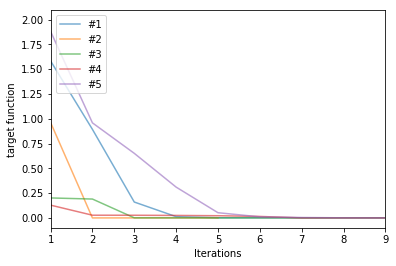

In [77]:
plt.xlim([1,9])
y1 = y_his[0,12:28]
y2 = y_his[1,12:18]
y3 = y_his[2,12:22]
y4 = y_his[3,12:28]
y5 = y_his[4,12:28]
#std = np.std(y_his[:,12:],axis = 0).reshape(1,-1)
#mean = np.mean(y_his[:,12:],axis = 0).reshape(1,-1)
#x = np.arange(1,mean.shape[1]+1,1).reshape(1,-1)

plt.plot(y1,alpha = 0.6)
plt.plot(y2,alpha = 0.6)
plt.plot(y3,alpha = 0.6)
plt.plot(y4,alpha = 0.6)
plt.plot(y5,alpha = 0.6)
#plt.errorbar(x, mean, yerr=std, marker='s',markersize=1)
plt.xlabel("Iterations",fontsize=10)
plt.ylabel("target function",fontsize=10)
plt.legend(['#1','#2', '#3', '#4','#5'], loc='upper left')
plt.show()   

## Practical Application! 
## MNIST with Neural Network Model

After verifying the viability and robustness of our model for Bayesian Optimization of hyperparameters, we decided to apply the algorithm on the classic machine learning training set - `MNIST`. In HW7, we've already built the **neural network model** in combination with **logistic regression** and train it to make predictions with high accuracy. We were asked to test different regularization parameters in the problem set, and naively, what we did was run the model three times by manually selecting regularization parameters in representive of different order of magnitude, e.g., 0.01,0.1 and 1 and compare their performance. This naive approach is time-consuming and inefficient, and we could not make sure whether our random experiments covered the optimal hyperparameters.

Below we apply Bayesian optimization to tune the hyperparameters of the neural network. Specifically, for the 1D case we tuned the **learning rate** and for the 2D case we tuned the **learning rate** and the **regularization** terms.

In [17]:
# Regression Parent Class
class Regression(object):
    
    def __init__(self):
        self.params = dict()
    
    def get_params(self, k):
        return self.params.get(k, None)
    
    def set_params(self, **kwargs):
        for k,v in kwargs.items():
            self.params[k] = v 
                    
    def fit(self, X, y):
        raise NotImplementedError()
        
    def predict(self, X):
        raise NotImplementedError()
        
    def score(self, X, y):
        raise NotImplementedError()

In [18]:
## Our PyTorch implementation of Logistic Regression
class LRPyTorch(nn.Module):

    ## the constructor is where we'll define all our layers (input, hidden, and output)
    def __init__(self):

        ## this line creates an instance of our parent (or base) class which in this case
        ## is nn.Module.
        super().__init__()

        ## in the lines below we'll create instance variables and assign them torch.nn Models
        ## in order to create our layers.  You should ordinarily have one variable definition for each layer
        ## in your neural network except for the output layer.  The output layer is defined by the number of
        ## outputs in your last layer. Since we're dealing with simple Artificial Neural Networks, we should
        ## predominantly be using nn.Linear.  
        self.l1 = nn.Linear(784, 10)

 
    # forwards takes as a parameter x -- the batch of inputs that we want to feed into our neural network model
    # and returns the output of the model ... i.e. the results of the output layer of the model after forward
    # propagation through our model. practically this means you should call each layer you defined in the
    # constructor in sequence plus any activation functions on each layer.
    def forward(self, x):
     
        # call all our layers on our input (in this case we only need one)
        x = self.l1(x)

        # Since we're using Cross Entropy Loss
        # we can return our output directly
        return x

In [19]:
class MNIST_Logistic_Regression(Regression):
    
    def __init__(self, learning_rate=0.1, batch_size=256, epochs=10,regularization = 0.01):
        
        super().__init__()     
        
        ## Load MNIST Data
        train_dataset, test_dataset, train_loader, test_loader, valid_loader = self.load_data()
        
        
        ## Add Datasets and Data Loaders to our params
        self.set_params(train_dataset = train_dataset, 
                        train_loader = train_loader,
                        test_dataset = test_dataset,
                        test_loader = test_loader,
                        valid_loader = valid_loader) 
        
        ## Here we instantiate the PyTorch model that we so nicely defined previously
        model = LRPyTorch()

        ## Here we define our loss function
        criterion = nn.CrossEntropyLoss()

        ## Here we define our optimizer
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,weight_decay = regularization)
           
        ## Add Datasets and Data Loaders to our params
        self.set_params(optimizer=optimizer, 
                        learning_rate=learning_rate,
                        batch_size=batch_size,
                        model=model,
                        criterion=criterion,
                        epochs=epochs)   
        
    def load_data(self):
        """load the MNIST training and test sets from MNIST"""
        train_dataset = datasets.MNIST(root='./hw3_data',
                                    train=True,
                                    transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,)),
                                     ]),
                                    download=True)

        ## test set data
        test_dataset = datasets.MNIST(root='./hw3_data',
                                   train=False,
                                   transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,)),
                                     ]),
                                   download=True)

        indices = list(range(len(train_dataset))) # start with all the indices in training set
        split = 10000 # define the split size
        batch_size = 256 # Define your batch_size

        # Random, non-contiguous split
        valid_idx = np.random.choice(indices, size=split, replace=False)
        train_idx = list(set(indices) - set(valid_idx))

        # define our samplers -- we use a SubsetRandomSampler because it will return
        # a random subset of the split defined by the given indices without replacement
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                                   batch_size=batch_size, sampler=train_sampler)

        valid_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                                        batch_size=batch_size, sampler=valid_sampler)

        test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                                  batch_size=len(test_dataset),
                                                  shuffle=False)

        return (train_dataset, test_dataset, train_loader, test_loader, valid_loader)
    
    # leave it here
    def sample_training_images(self):
        """Create a set of sample images from the MNIST training images"""
        
        training_set = self.get_params('train_dataset')
        sample_indices = np.random.choice(training_set.train_data.size(0), 10)
        
        sample_images = training_set.train_data[sample_indices,:,:].numpy()
        sample_labels = [training_set.train_labels[x] for x in sample_indices]
        
        self.set_params(sample_training_images=sample_images)
        self.set_params(sample_training_labels=sample_labels)
    
    
    # leave it here
    def save_misclassified(self, predictions, images, labels):
        """Create and save a set of sample images misclassified images by the model"""
           
        mislabeled_indices = [index for index,value in enumerate(np.array(predictions) == labels) if value==False]
        
        sample_images = images[mislabeled_indices,:,:]
        sample_labels = [predictions[x] for x in mislabeled_indices]
        true_labels = [labels[x] for x in mislabeled_indices]

        self.set_params(misclassified_images=sample_images)
        self.set_params(misclassified_labels=sample_labels)
        self.set_params(misclassified_true_labels=true_labels)
        
    #leave it here    
    def viz_training_images(self):
        """Visualize/Plot sample training images"""
        
        if not self.get_params('training_labels'):
            self.sample_training_images()
        
        # get the images and labels
        sample_images = self.get_params("sample_training_images")
        sample_labels = self.get_params("sample_training_labels")
        
        fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(20, 10))
        plt.suptitle("Some Sample Images from MNIST", fontsize=20, weight='heavy')

        for i in range(5):
            ax1[i].imshow(sample_images[i])
            ax1[i].set_title("MNIST Label: {}".format(sample_labels[i]))
            ax2[i].imshow(sample_images[i+5])
            ax2[i].set_title("MNIST Label: {}".format(sample_labels[i+5]), weight='bold')
            
        plt.show()

    def viz_misclassified_images(self):
        """Visualize/Plot misclassified training images"""

        # get the images and labels
        sample_images = self.get_params("misclassified_images")
        sample_labels = self.get_params("misclassified_labels")
        true_labels = self.get_params("misclassified_true_labels")
        
        if not sample_labels:
            raise(Exception("Please run predict() or score() with save_misclassified=True"))

        fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(20, 10))
        plt.suptitle("Some Sample Misclassified Images", fontsize=20, weight='heavy')
        
        for i in range(5):
            ax1[i].imshow(sample_images[i][0])
            ax1[i].set_title("MNIST Label: {} Classified: {}".format(true_labels[i], sample_labels[i]), weight='bold')
            ax2[i].imshow(sample_images[i+5][0])
            ax2[i].set_title("MNIST Label: {} Classified: {}".format(true_labels[i+5], sample_labels[i+5]), weight='bold')

        plt.show()
        
    
    ## Stolen from excellent visualization from submission from Madeleine Duran/Sarah Walker
    def viz_training_loss(self, epochs=10):
        """Visualize/Plot our training loss"""
        
        losses = self.get_params("training_losses")
        
        if type(losses) == type(None):
            raise("Please run fit() to train data")
        
        fig, axes = plt.subplots(nrows=1, ncols=epochs, figsize=(20,5), sharex=True, sharey=True)
        
        for i in range(epochs):
            axes[i].plot(range(len(losses[i])), losses[i])
            axes[i].set_title("epoch {}".format(i))
            if i % 2 == 1:
                axes[i].axvspan(0, len(self.get_params('train_loader')), facecolor='gray', alpha=0.2)
        plt.subplots_adjust(wspace=0)
        plt.show()
        
    
    def predict(self, dataset='Test', save_misclassified=True):
        """Classify images based on the fitted logistic regression model"""

        # Get Loader   
        if dataset == 'Test':
            loader = self.get_params('test_loader')
        elif dataset == 'Valid':
            loader = self.get_params('valid_loader')
        elif dataset == 'Train':
            loader = self.get_params('train_loader')

        
        predictions = []
        correct = 0
        model = self.get_params('model')
        dataset_labels = np.array(0)
        dataset_images = np.zeros(shape = (1,1,28,28))

        for inputs, labels in loader:

            # append inputs and labels into dataset_labels and dataset_images
            dataset_labels = np.append(dataset_labels,labels.numpy())
            dataset_images = np.append(dataset_images,inputs.numpy(),axis = 0)
            ## get the inputs from the dataloader and turn into a variable for 
            ## feeding to the model
            inputs = Variable(inputs)

            ## Reshape so that batches work properly
            inputs = inputs.view(-1, 28*28)

            # run our model on the inputs
            outputs = model(inputs)

            # get the class of the max log-probability (1) for axis [1] for index max function output
            pred = outputs.data.max(1)[1]

            correct += (pred == labels).sum()

            # append current batch of predictions to our list
            predictions += list(pred.numpy())
            
        dataset_labels = dataset_labels[1:]
        
        dataset_images = dataset_images[1:,:,:,:]


        if save_misclassified:
            self.save_misclassified(predictions, dataset_images, dataset_labels)
            
        self.set_params(predictions=predictions, 
                        correct_predictions=correct,
                        prediction_dataset_length=len(dataset_labels),
                        prediction_dataset_labels= dataset_labels
                       )
        return np.array(predictions)
    
    
    def score(self, dataset='Test', save_misclassified=True ):
        """Calculate accuracy score based upon model classification"""
        
        self.predict(dataset=dataset, save_misclassified=save_misclassified)
        correct = self.get_params('correct_predictions')
        total = self.get_params('prediction_dataset_length')
        
#         print('Dataset: {} \nAccuracy: {}/{} ({:.1f}%)\n'.format(
#             dataset, correct, total, 100.0 * correct / total))
        
        return(float(correct)/float(total))
        
        
    def fit(self):
        """Fit our logistic regression model on MNIST training set"""
        
        ## We defined a number of variables in our constructor -- let's reclaim them here
        optimizer=self.get_params("optimizer")
        model=self.get_params("model")
        epochs=self.get_params("epochs")
        criterion=self.get_params("criterion")
        train_loader=self.get_params("train_loader")
        
        ## Get the Total size of training set
        #self.get_params('train_dataset')
        training_size = 50000
        
        iterations = int(np.ceil(training_size/self.get_params("batch_size")))
        
        ## We need something to keep track of our losses
        losses = np.zeros((epochs, iterations)) 
  
        
        ## Our training loop.  We can loop over a fixed number of epochs or
        ## using a sensitivity parameter (i.e. until net change in loss is
        ## below a certain tolerance).  Here we iterate over a fixed number of
        ## epochs
        for epoch in range(epochs):

            for batch_index, (inputs, labels) in enumerate(train_loader):

                inputs, labels = Variable(inputs), Variable(labels)
                inputs = inputs.view(-1, 28*28)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                ## count the loss
                losses[epoch,batch_index] = loss.data[0]

                # we run backpropagation on the loss variable which repopulates the gradients all the way
                # back through our model to the input layer
                loss.backward()

                # Use the gradients calculated in the backprop that took place in .backwards() to do a new
                # gradient descent step
                optimizer.step()
                
        ## Set Loss Matrix for visualizing
        self.set_params(training_losses=losses)
        
        return self
    
    def fit_acc(self):
        """Fit our logistic regression model on MNIST training set"""
        
        ## We defined a number of variables in our constructor -- let's reclaim them here
        optimizer=self.get_params("optimizer")
        model=self.get_params("model")
        epochs=self.get_params("epochs")
        criterion=self.get_params("criterion")
        train_loader=self.get_params("train_loader")
        
        ## Get the Total size of training set
        #self.get_params('train_dataset')
        training_size = 50000
        
        iterations = int(np.ceil(training_size/self.get_params("batch_size")))
        
        ## We need something to keep track of our losses
        losses = np.zeros((epochs, iterations)) 
        accuracy_valid = np.zeros((1,epochs))
  
        for epoch in range(epochs):

            for batch_index, (inputs, labels) in enumerate(train_loader):

                inputs, labels = Variable(inputs), Variable(labels)
                inputs = inputs.view(-1, 28*28)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                losses[epoch,batch_index] = loss.item()
                loss.backward()
                optimizer.step()
            accu = self.score(dataset='Valid', save_misclassified=False )
            
            accuracy_valid[0,epoch] = accu
        ## Set Loss Matrix for visualizing
        self.set_params(training_losses = losses)
        self.set_params(accuracy = accuracy_valid)
        return self

To apply our Bayesian optimization on the real world dataset, we used MNIST and first aim to tune the 1D parameter: learning rate. In reminiscent of the painful tuning process in HW7 that we manually and blindly tune the parameters to search for better pritiction accuracy on test set, now automatic search by Bayesian optimization is supported by strong theory and is less labor-demanding.

In [82]:
def f(lr):
    MLR = MNIST_Logistic_Regression()
    MLR.set_params(learning_rate=lr, epochs= 10,batch_size = 256, regularization = 0.01)
    MLR.fit_acc()
    return 1-MLR.get_params('accuracy')[0,-1]
f_range = [0.1,20]

In [83]:
baye_1d = BayeOpt(target_func=f,x_range=f_range,init_points=3)


-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1} 



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


x y list: [[ 0.1       ]
 [10.05      ]
 [20.        ]
 [10.27486406]
 [11.97338789]
 [ 4.46887135]] [0.0921 0.0859 0.0828 0.082  0.089  0.0905]


Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 2500/2500 [00:09<00:00, 259.39it/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


grad: [-2.68715605e-05]
x_next: [10.05002688]
grad: [-5.16947596e-07]
x_next: [10.2694797]
grad: [4.13297868e-07]
x_next: [10.24339791]
grad: [1.00744066e-07]
x_next: [20.]
grad: [-1.76855058e-06]
x_next: [10.05]
grad: [0.]
x_next: [10.05]
grad: [-6.75076314e-06]
x_next: [10.25093662]
grad: [7.48034447e-06]
x_next: [10.273208]
grad: [-3.57873453e-07]
x_next: [10.05]
grad: [4.56977338e-05]
x_next: [10.04995429]

x new: [11.12870034]

y new: 0.08779999999999999

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1} 



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


x y list: [[ 0.1       ]
 [10.05      ]
 [20.        ]
 [10.27486406]
 [11.97338789]
 [ 4.46887135]
 [11.12870034]] [0.0921 0.0859 0.0828 0.082  0.089  0.0905 0.0878]


Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 2500/2500 [00:09<00:00, 258.68it/s]
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


grad: [4.44622637e-06]
x_next: [10.28915233]
grad: [-5.4903998e-07]
x_next: [10.06097308]
grad: [0.]
x_next: [10.05]
grad: [-1.14643538e-06]
x_next: [10.03468554]
grad: [-3.60653347e-06]
x_next: [9.72986173]
grad: [-6.67434857e-08]
x_next: [10.30372001]
grad: [-4.64819155e-07]
x_next: [10.18303561]
grad: [2.61291639e-06]
x_next: [10.31505758]
grad: [1.24787333e-06]
x_next: [9.87181418]
grad: [2.62945048e-06]
x_next: [10.300475]

x new: [10.11387751]

y new: 0.08779999999999999

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1} 



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


x y list: [[ 0.1       ]
 [10.05      ]
 [20.        ]
 [10.27486406]
 [11.97338789]
 [ 4.46887135]
 [11.12870034]
 [10.11387751]] [0.0921 0.0859 0.0828 0.082  0.089  0.0905 0.0878 0.0878]


Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 2500/2500 [00:09<00:00, 253.40it/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


grad: [-8.14452672e-08]
x_next: [10.25568163]
grad: [-4.84334794e-07]
x_next: [10.15644933]
grad: [9.01882735e-07]
x_next: [9.51690217]
grad: [2.82421656e-06]
x_next: [10.44848045]
grad: [5.689893e-08]
x_next: [10.05]
grad: [-1.17171897e-06]
x_next: [10.11315959]
grad: [4.92162734e-06]
x_next: [10.35034303]
grad: [7.93375782e-07]
x_next: [9.98374675]
grad: [-3.06974932e-05]
x_next: [10.05003073]
grad: [5.77879758e-06]
x_next: [9.28371957]

x new: [10.02085133]

y new: 0.12009999999999998


array([10.27486406])

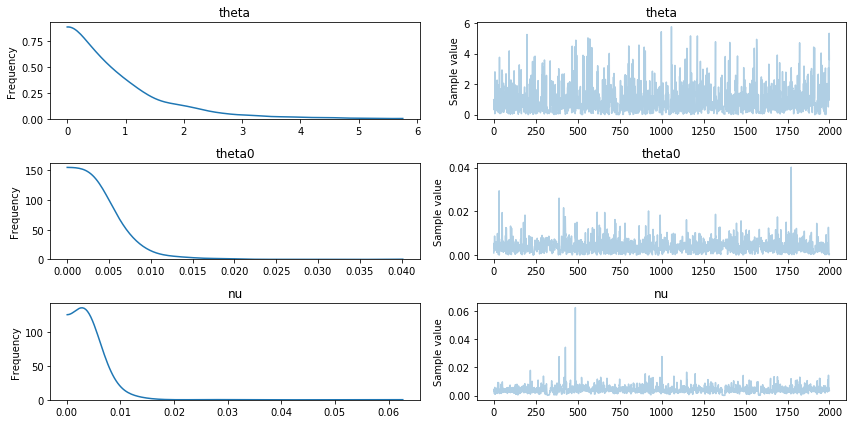

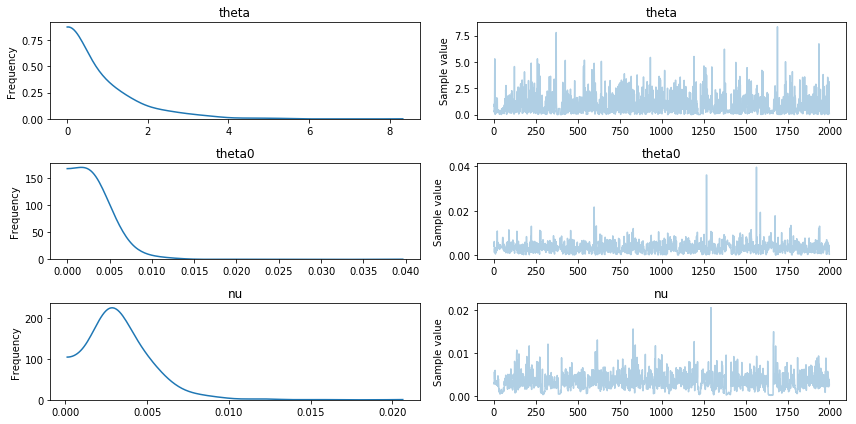

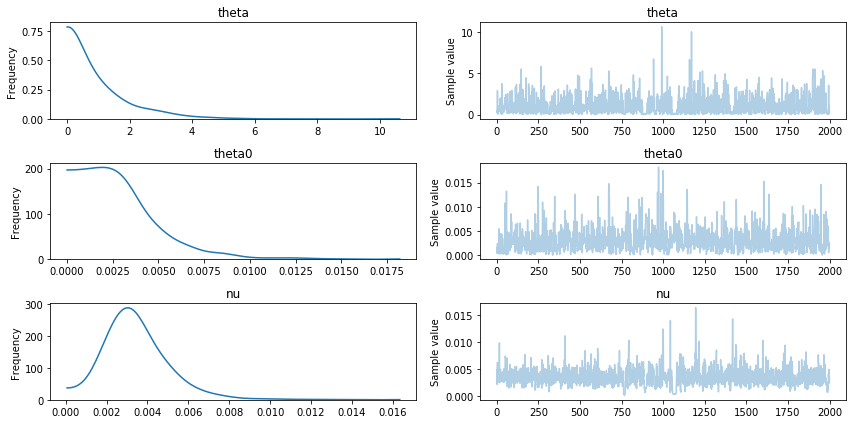

In [84]:
baye_1d.Iteration(mode = "MCMC",acquisition = "EI")

In [35]:
def MNIST_2D(params):
    MLR = MNIST_Logistic_Regression()
    MLR.set_params(learning_rate=params[1], epochs= 12,batch_size = 256, regularization = params[0])
    MLR.fit_acc()
    return 1-MLR.get_params('accuracy')[0,-1]
MNIST_2D_range = [[0.1,0.01],[20,1]]

In [36]:
baye_2d = BayeOpt(target_func=MNIST_2D,x_range=MNIST_2D_range,init_points=6)


-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 



/Users/lechenqian/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


x y list: [[1.00000000e-01 1.00000000e-02]
 [1.00500000e+01 5.05000000e-01]
 [2.00000000e+01 1.00000000e+00]
 [1.88273279e+01 6.14039650e-01]
 [1.16488571e+01 2.61223119e-01]
 [1.19503347e+01 1.05260586e-01]
 [1.94127078e+01 6.45387851e-01]
 [2.82502961e+00 5.22692779e-01]
 [5.95488423e+00 9.79121867e-02]] [0.0968 0.0964 0.0924 0.0994 0.0888 0.101  0.117  0.085  0.0956]


Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:07<00:00, 211.69it/s]
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


grad: [-5.10234216e-06  8.89566198e-07]
x_next: [11.36646798  0.39422676]
grad: [-5.72805692e-07  6.93889390e-09]
x_next: [10.05   0.505]
grad: [-1.17961196e-08 -3.00107161e-08]
x_next: [2.83879016 0.52265901]
grad: [0. 0.]
x_next: [10.05   0.505]

x new: [8.57631454 0.48172144]

y new: 0.09189999999999998

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


x y list: [[1.00000000e-01 1.00000000e-02]
 [1.00500000e+01 5.05000000e-01]
 [2.00000000e+01 1.00000000e+00]
 [1.88273279e+01 6.14039650e-01]
 [1.16488571e+01 2.61223119e-01]
 [1.19503347e+01 1.05260586e-01]
 [1.94127078e+01 6.45387851e-01]
 [2.82502961e+00 5.22692779e-01]
 [5.95488423e+00 9.79121867e-02]
 [8.57631454e+00 4.81721442e-01]] [0.0968 0.0964 0.0924 0.0994 0.0888 0.101  0.117  0.085  0.0956 0.0919]


Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:14<00:00, 101.41it/s]
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


grad: [5.55111512e-09 2.77555756e-09]
x_next: [10.05   0.505]
grad: [6.49402407e-06 2.81458884e-07]
x_next: [11.40613822  0.38712473]
grad: [0. 0.]
x_next: [10.05   0.505]
grad: [7.92768629e-08 1.68268177e-08]
x_next: [10.05   0.505]

x new: [10.38903455  0.47553118]

y new: 0.08789999999999998

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


x y list: [[1.00000000e-01 1.00000000e-02]
 [1.00500000e+01 5.05000000e-01]
 [2.00000000e+01 1.00000000e+00]
 [1.88273279e+01 6.14039650e-01]
 [1.16488571e+01 2.61223119e-01]
 [1.19503347e+01 1.05260586e-01]
 [1.94127078e+01 6.45387851e-01]
 [2.82502961e+00 5.22692779e-01]
 [5.95488423e+00 9.79121867e-02]
 [8.57631454e+00 4.81721442e-01]
 [1.03890346e+01 4.75531183e-01]] [0.0968 0.0964 0.0924 0.0994 0.0888 0.101  0.117  0.085  0.0956 0.0919
 0.0879]


Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:18<00:00, 104.65it/s]
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


grad: [-4.72625411e-07 -2.22044605e-08]
x_next: [10.43823588  0.47115599]
grad: [-6.43929354e-07  1.84574578e-07]
x_next: [10.05   0.505]
grad: [-8.44810333e-08  3.95100619e-06]
x_next: [9.97076953 0.47404608]
grad: [-7.02216063e-07  2.01366701e-06]
x_next: [10.45484685  0.46456627]

x new: [10.22846306  0.47869209]

y new: 0.08650000000000002

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


x y list: [[1.00000000e-01 1.00000000e-02]
 [1.00500000e+01 5.05000000e-01]
 [2.00000000e+01 1.00000000e+00]
 [1.88273279e+01 6.14039650e-01]
 [1.16488571e+01 2.61223119e-01]
 [1.19503347e+01 1.05260586e-01]
 [1.94127078e+01 6.45387851e-01]
 [2.82502961e+00 5.22692779e-01]
 [5.95488423e+00 9.79121867e-02]
 [8.57631454e+00 4.81721442e-01]
 [1.03890346e+01 4.75531183e-01]
 [1.02284631e+01 4.78692085e-01]] [0.0968 0.0964 0.0924 0.0994 0.0888 0.101  0.117  0.085  0.0956 0.0919
 0.0879 0.0865]


Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:17<00:00, 84.85it/s] 
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


grad: [-1.58019431e-05 -7.51326085e-06]
x_next: [10.05001581  0.50500752]
grad: [-1.65839564e-07  0.00000000e+00]
x_next: [10.05   0.505]
grad: [9.33541439e-07 3.46545709e-06]
x_next: [10.5343978   0.48376172]
grad: [1.42364419e-06 3.12657886e-06]
x_next: [10.88626986  0.40325024]

x new: [10.38017087  0.47425487]

y new: 0.08399999999999996

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


x y list: [[1.00000000e-01 1.00000000e-02]
 [1.00500000e+01 5.05000000e-01]
 [2.00000000e+01 1.00000000e+00]
 [1.88273279e+01 6.14039650e-01]
 [1.16488571e+01 2.61223119e-01]
 [1.19503347e+01 1.05260586e-01]
 [1.94127078e+01 6.45387851e-01]
 [2.82502961e+00 5.22692779e-01]
 [5.95488423e+00 9.79121867e-02]
 [8.57631454e+00 4.81721442e-01]
 [1.03890346e+01 4.75531183e-01]
 [1.02284631e+01 4.78692085e-01]
 [1.03801709e+01 4.74254871e-01]] [0.0968 0.0964 0.0924 0.0994 0.0888 0.101  0.117  0.085  0.0956 0.0919
 0.0879 0.0865 0.084 ]


Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:08<00:00, 180.35it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


grad: [9.47852907e-07 1.57929225e-06]
x_next: [10.37747258  0.47178515]
grad: [ 1.15185639e-07 -2.60902411e-07]
x_next: [10.36131939  0.47325679]
grad: [-7.80989856e-06  1.31439998e-06]
x_next: [10.06807349  0.58190274]
grad: [ 4.29851467e-06 -8.20133891e-07]
x_next: [10.37286133  0.47367954]

x new: [10.2949317   0.50015606]

y new: 0.08640000000000003

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


x y list: [[1.00000000e-01 1.00000000e-02]
 [1.00500000e+01 5.05000000e-01]
 [2.00000000e+01 1.00000000e+00]
 [1.88273279e+01 6.14039650e-01]
 [1.16488571e+01 2.61223119e-01]
 [1.19503347e+01 1.05260586e-01]
 [1.94127078e+01 6.45387851e-01]
 [2.82502961e+00 5.22692779e-01]
 [5.95488423e+00 9.79121867e-02]
 [8.57631454e+00 4.81721442e-01]
 [1.03890346e+01 4.75531183e-01]
 [1.02284631e+01 4.78692085e-01]
 [1.03801709e+01 4.74254871e-01]
 [1.02949317e+01 5.00156056e-01]] [0.0968 0.0964 0.0924 0.0994 0.0888 0.101  0.117  0.085  0.0956 0.0919
 0.0879 0.0865 0.084  0.0864]


Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:09<00:00, 150.66it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


grad: [-2.02717617e-06  8.59360326e-07]
x_next: [10.42506507  0.46003047]
grad: [-1.72578965e-06 -1.89995589e-07]
x_next: [10.35776613  0.47756289]
grad: [6.25801494e-07 5.04440240e-06]
x_next: [10.56071062  0.45639941]
grad: [-1.37652043e-05 -1.01568060e-06]
x_next: [10.05001377  0.50500102]

x new: [10.3483889   0.47474845]

y new: 0.0837

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


x y list: [[1.00000000e-01 1.00000000e-02]
 [1.00500000e+01 5.05000000e-01]
 [2.00000000e+01 1.00000000e+00]
 [1.88273279e+01 6.14039650e-01]
 [1.16488571e+01 2.61223119e-01]
 [1.19503347e+01 1.05260586e-01]
 [1.94127078e+01 6.45387851e-01]
 [2.82502961e+00 5.22692779e-01]
 [5.95488423e+00 9.79121867e-02]
 [8.57631454e+00 4.81721442e-01]
 [1.03890346e+01 4.75531183e-01]
 [1.02284631e+01 4.78692085e-01]
 [1.03801709e+01 4.74254871e-01]
 [1.02949317e+01 5.00156056e-01]
 [1.03483889e+01 4.74748448e-01]] [0.0968 0.0964 0.0924 0.0994 0.0888 0.101  0.117  0.085  0.0956 0.0919
 0.0879 0.0865 0.084  0.0864 0.0837]


Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:09<00:00, 159.09it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


grad: [-2.52662474e-07  1.70848578e-07]
x_next: [10.34076606  0.46796327]
grad: [-2.58734006e-07 -4.71541209e-07]
x_next: [10.40748097  0.47021776]
grad: [4.66965876e-06 3.39170966e-06]
x_next: [10.33189545  0.46903561]
grad: [-7.26829621e-06  3.85336294e-06]
x_next: [10.40681485  0.46276725]

x new: [10.37173934  0.46749597]

y new: 0.08809999999999996

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


x y list: [[1.00000000e-01 1.00000000e-02]
 [1.00500000e+01 5.05000000e-01]
 [2.00000000e+01 1.00000000e+00]
 [1.88273279e+01 6.14039650e-01]
 [1.16488571e+01 2.61223119e-01]
 [1.19503347e+01 1.05260586e-01]
 [1.94127078e+01 6.45387851e-01]
 [2.82502961e+00 5.22692779e-01]
 [5.95488423e+00 9.79121867e-02]
 [8.57631454e+00 4.81721442e-01]
 [1.03890346e+01 4.75531183e-01]
 [1.02284631e+01 4.78692085e-01]
 [1.03801709e+01 4.74254871e-01]
 [1.02949317e+01 5.00156056e-01]
 [1.03483889e+01 4.74748448e-01]
 [1.03717393e+01 4.67495974e-01]] [0.0968 0.0964 0.0924 0.0994 0.0888 0.101  0.117  0.085  0.0956 0.0919
 0.0879 0.0865 0.084  0.0864 0.0837 0.0881]


Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:09<00:00, 159.05it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


grad: [-4.74453376e-06 -4.22368304e-06]
x_next: [10.32270087  0.4694091 ]
grad: [-2.47276158e-06 -6.89639318e-07]
x_next: [10.4183764   0.47043251]
grad: [-1.07569372e+06  1.03953651e-04]
x_next: [10.05   0.505]
grad: [-6.10180309e-06  1.32164245e-06]
x_next: [10.74210279  0.43929346]

x new: [10.38329502  0.47103377]

y new: 0.09430000000000005

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


x y list: [[1.00000000e-01 1.00000000e-02]
 [1.00500000e+01 5.05000000e-01]
 [2.00000000e+01 1.00000000e+00]
 [1.88273279e+01 6.14039650e-01]
 [1.16488571e+01 2.61223119e-01]
 [1.19503347e+01 1.05260586e-01]
 [1.94127078e+01 6.45387851e-01]
 [2.82502961e+00 5.22692779e-01]
 [5.95488423e+00 9.79121867e-02]
 [8.57631454e+00 4.81721442e-01]
 [1.03890346e+01 4.75531183e-01]
 [1.02284631e+01 4.78692085e-01]
 [1.03801709e+01 4.74254871e-01]
 [1.02949317e+01 5.00156056e-01]
 [1.03483889e+01 4.74748448e-01]
 [1.03717393e+01 4.67495974e-01]
 [1.03832950e+01 4.71033770e-01]] [0.0968 0.0964 0.0924 0.0994 0.0888 0.101  0.117  0.085  0.0956 0.0919
 0.0879 0.0865 0.084  0.0864 0.0837 0.0881 0.0943]


Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:09<00:00, 155.54it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


grad: [2.66947922e-06 3.28088251e-06]
x_next: [10.40916126  0.47557567]
grad: [ 3.76001313e-07 -1.89718033e-06]
x_next: [10.41339943  0.47810511]
grad: [5.67428049e-07 3.67501168e-07]
x_next: [10.32837314  0.48098409]
grad: [ 1.10978934e-06 -4.55364912e-08]
x_next: [10.35985919  0.47914377]

x new: [10.37769826  0.47845216]

y new: 0.08330000000000004

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


x y list: [[1.00000000e-01 1.00000000e-02]
 [1.00500000e+01 5.05000000e-01]
 [2.00000000e+01 1.00000000e+00]
 [1.88273279e+01 6.14039650e-01]
 [1.16488571e+01 2.61223119e-01]
 [1.19503347e+01 1.05260586e-01]
 [1.94127078e+01 6.45387851e-01]
 [2.82502961e+00 5.22692779e-01]
 [5.95488423e+00 9.79121867e-02]
 [8.57631454e+00 4.81721442e-01]
 [1.03890346e+01 4.75531183e-01]
 [1.02284631e+01 4.78692085e-01]
 [1.03801709e+01 4.74254871e-01]
 [1.02949317e+01 5.00156056e-01]
 [1.03483889e+01 4.74748448e-01]
 [1.03717393e+01 4.67495974e-01]
 [1.03832950e+01 4.71033770e-01]
 [1.03776983e+01 4.78452162e-01]] [0.0968 0.0964 0.0924 0.0994 0.0888 0.101  0.117  0.085  0.0956 0.0919
 0.0879 0.0865 0.084  0.0864 0.0837 0.0881 0.0943 0.0833]


Sequential sampling (1 chains in 1 job)
NUTS: [nu, theta0, theta]
100%|██████████| 1500/1500 [00:07<00:00, 187.52it/s]
The acceptance probability does not match the target. It is 0.7212817965910788, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


grad: [ 1.24149822e-06 -7.34655392e-07]
x_next: [10.32110354  0.48401844]
grad: [-1.13229738e-06  2.90440415e-06]
x_next: [10.58679024  0.45942567]
grad: [ 9.67533345e-06 -1.39020739e-06]
x_next: [10.42508851  0.47345231]
grad: [-3.59087760e-08  6.46184495e-08]
x_next: [10.4662731   0.47107142]

x new: [10.44981385  0.47199196]

y new: 0.10170000000000001


array([10.37769826,  0.47845216])

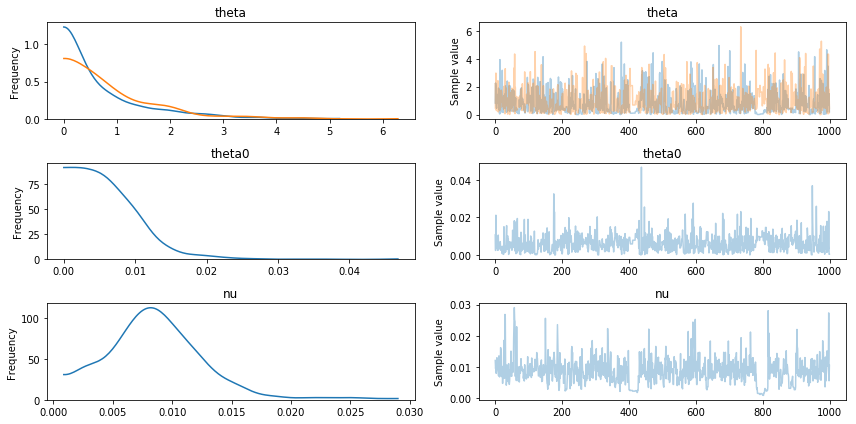

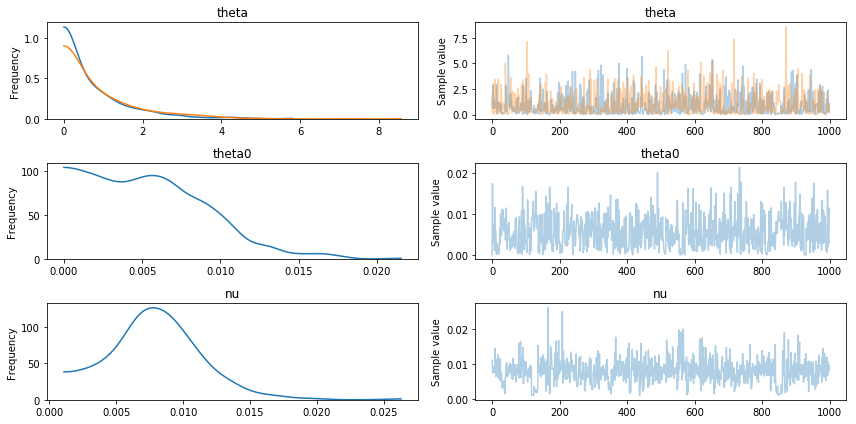

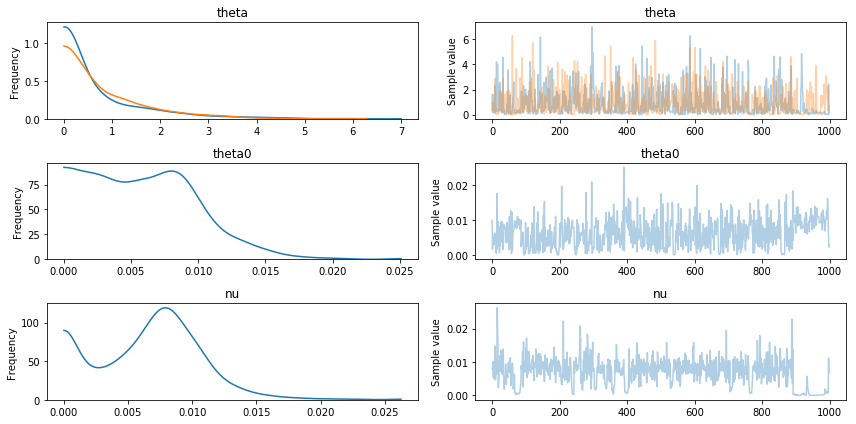

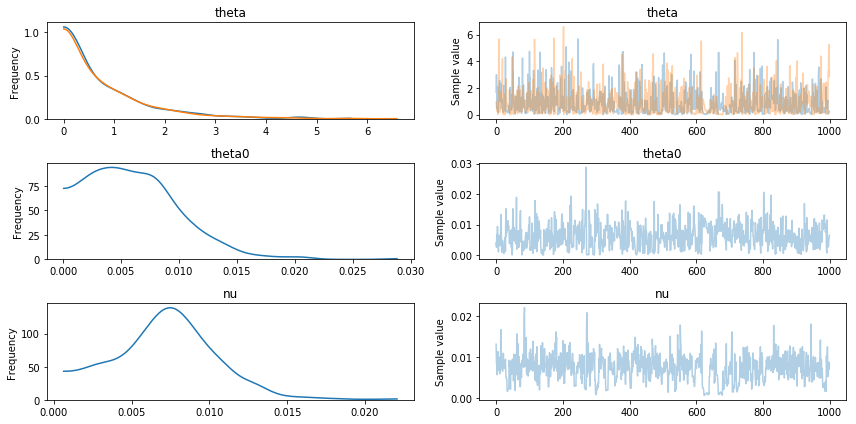

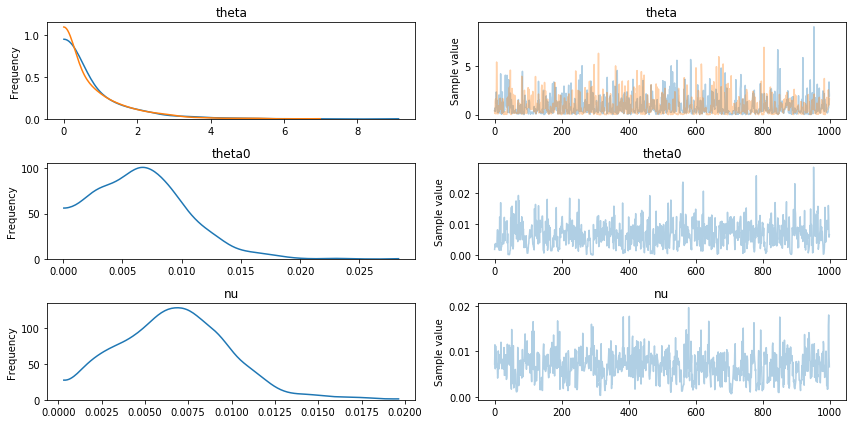

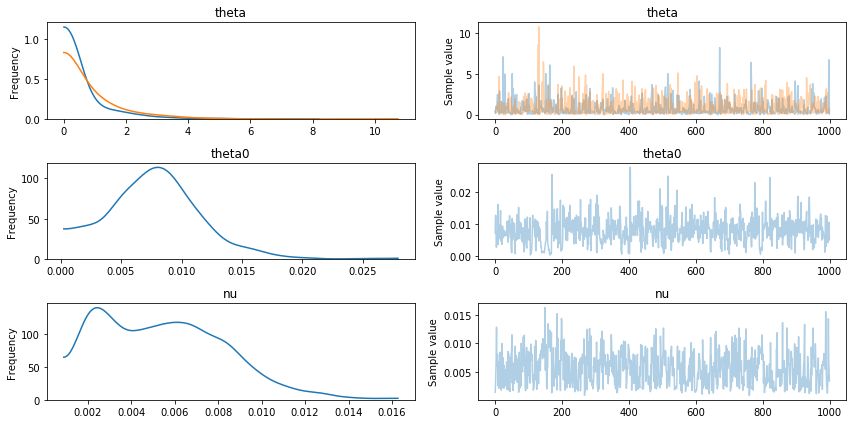

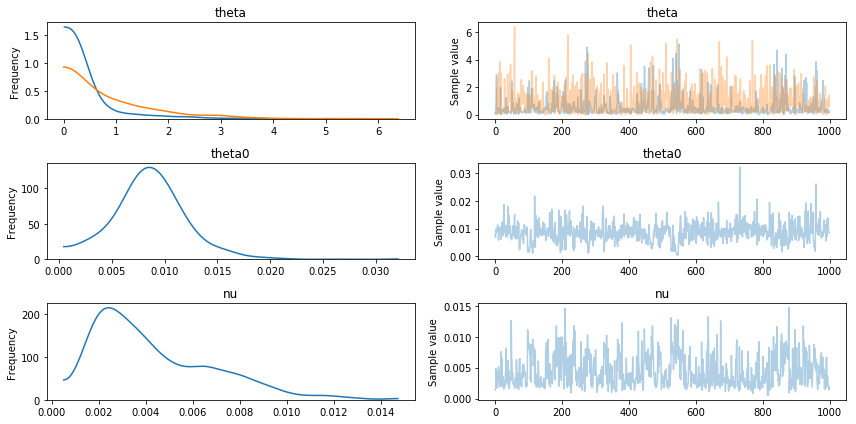

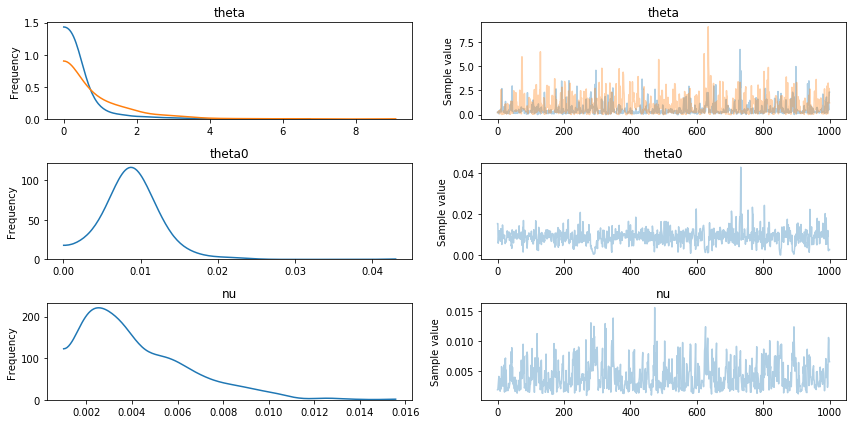

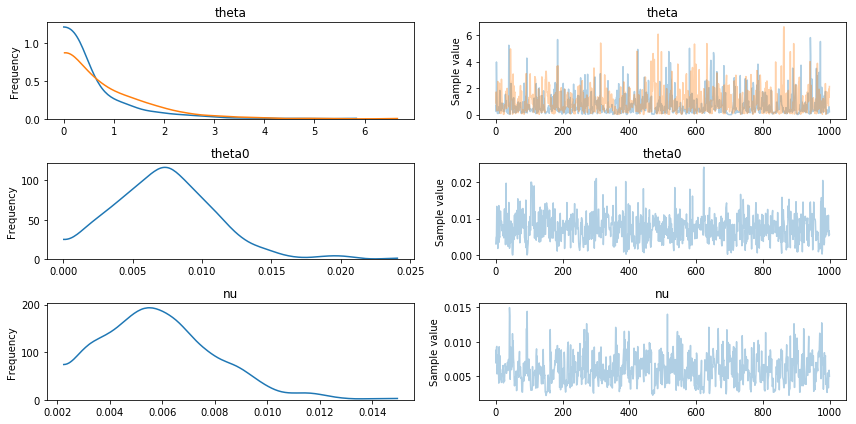

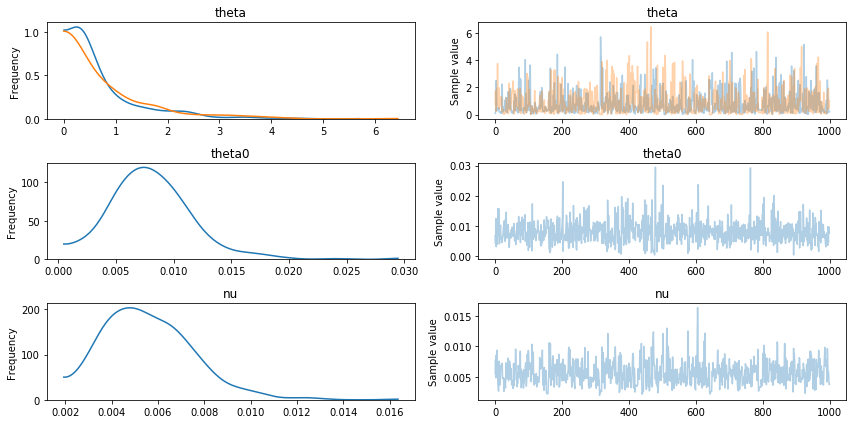

In [37]:
baye_2d.Iteration(mode = "MCMC",acquisition = "EI")

In [39]:
baye_2d_OPT_EI = BayeOpt(target_func=MNIST_2D,x_range=MNIST_2D_range,init_points=9)
baye_2d_OPT_EI.Iteration(mode = "OPT",acquisition = "EI")


-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 



/Users/lechenqian/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


x y list: [[1.00000000e-01 1.00000000e-02]
 [1.00500000e+01 5.05000000e-01]
 [2.00000000e+01 1.00000000e+00]
 [1.56928507e+01 4.31456525e-01]
 [6.69349908e+00 4.20056987e-01]
 [1.79637279e+00 1.22305654e-01]
 [1.46446308e+01 4.40386875e-01]
 [1.39349161e+01 2.72607532e-01]
 [1.32967400e+01 1.00674321e-01]
 [1.10366553e+01 5.12914275e-01]
 [8.51708016e+00 8.36431518e-01]
 [7.25737648e+00 6.92392840e-01]] [0.0832 0.0944 0.0861 0.0893 0.094  0.0883 0.0955 0.0931 0.0894 0.1012
 0.0891 0.0984]


logp = 45.729, ||grad|| = 0.00024774: 100%|██████████| 42/42 [00:00<00:00, 681.39it/s]  


MAP: {'theta_log__': array([-0.53167741, -1.29344105]), 'theta0_log__': array(-5.30966571), 'nu_log__': array(-13.26910924), 'theta': array([0.58761847, 0.27432519]), 'theta0': array(0.00494358), 'nu': array(1.7270268e-06)}
grad: [2.39296430e-06 8.27558508e-06]
x_next: [8.65915728 0.85519942]

x new: [8.65915728 0.85519942]

y new: 0.08819999999999995

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[1.00000000e-01 1.00000000e-02]
 [1.00500000e+01 5.05000000e-01]
 [2.00000000e+01 1.00000000e+00]
 [1.56928507e+01 4.31456525e-01]
 [6.69349908e+00 4.20056987e-01]
 [1.79637279e+00 1.22305654e-01]
 [1.46446308e+01 4.40386875e-01]
 [1.39349161e+01 2.72607532e-01]
 [1.32967400e+01 1.00674321e-01]
 [1.10366553e+01 5.12914275e-01]
 [8.51708016e+00 8.36431518e-01]
 [7.25737648e+00 6.92392840e-01]
 [8.65915728e+00 8.55199415e-01]] [0.0832 0.0944 0.0861 0.0893 0.094  0.0883 0.0955 0.0931 0.0894 0

logp = 51.866, ||grad|| = 0.0032868: 100%|██████████| 38/38 [00:00<00:00, 787.13it/s]  


MAP: {'theta_log__': array([-0.1283061 , -0.95161337]), 'theta0_log__': array(-5.27557609), 'nu_log__': array(-15.02075893), 'theta': array([0.8795841 , 0.38611757]), 'theta0': array(0.00511501), 'nu': array(2.99617574e-07)}
grad: [-2.08930095e-06 -9.33463376e-06]
x_next: [8.97622785 0.8906141 ]

x new: [8.97622785 0.8906141 ]

y new: 0.08720000000000006

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[1.00000000e-01 1.00000000e-02]
 [1.00500000e+01 5.05000000e-01]
 [2.00000000e+01 1.00000000e+00]
 [1.56928507e+01 4.31456525e-01]
 [6.69349908e+00 4.20056987e-01]
 [1.79637279e+00 1.22305654e-01]
 [1.46446308e+01 4.40386875e-01]
 [1.39349161e+01 2.72607532e-01]
 [1.32967400e+01 1.00674321e-01]
 [1.10366553e+01 5.12914275e-01]
 [8.51708016e+00 8.36431518e-01]
 [7.25737648e+00 6.92392840e-01]
 [8.65915728e+00 8.55199415e-01]
 [8.97622785e+00 8.90614098e-01]] [0.0832 0.0944 0.0861 0.0893 

logp = 58.716, ||grad|| = 0.00084326: 100%|██████████| 48/48 [00:00<00:00, 75.42it/s]  


MAP: {'theta_log__': array([ 0.00366347, -0.80235703]), 'theta0_log__': array(-5.25229458), 'nu_log__': array(-16.69652552), 'theta': array([1.00367019, 0.44827113]), 'theta0': array(0.00523549), 'nu': array(5.60778169e-08)}
grad: [-2.30735570e-06 -2.80400703e-06]
x_next: [9.05185213 0.95153831]

x new: [9.05185213 0.95153831]

y new: 0.08509999999999995

-----------------------------------------------
prior: {'nu': 1, 'theta0': 1, 'theta': 1, 'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1} 

x y list: [[1.00000000e-01 1.00000000e-02]
 [1.00500000e+01 5.05000000e-01]
 [2.00000000e+01 1.00000000e+00]
 [1.56928507e+01 4.31456525e-01]
 [6.69349908e+00 4.20056987e-01]
 [1.79637279e+00 1.22305654e-01]
 [1.46446308e+01 4.40386875e-01]
 [1.39349161e+01 2.72607532e-01]
 [1.32967400e+01 1.00674321e-01]
 [1.10366553e+01 5.12914275e-01]
 [8.51708016e+00 8.36431518e-01]
 [7.25737648e+00 6.92392840e-01]
 [8.65915728e+00 8.55199415e-01]
 [8.97622785e+00 8.90614098e-01]
 [9.05185213e+00 9.51538309e-0

logp = 62.304, ||grad|| = 0.0012948: 100%|██████████| 46/46 [00:00<00:00, 575.49it/s]  


MAP: {'theta_log__': array([ 0.06729038, -1.54367719]), 'theta0_log__': array(-5.2104224), 'nu_log__': array(-16.65642729), 'theta': array([1.06960602, 0.21359423]), 'theta0': array(0.00545937), 'nu': array(5.837213e-08)}
grad: [ 8.30368760e-07 -2.74659119e-03]
x_next: [9.09354193 1.        ]
x new is old!


array([0.1 , 0.01])

From the above cell we can see that for GP OPT EI, the optimal regularization (params[0]) is 0.1, and the optimal learning rate (params[1]) is 0.01, while for GP MCMC EI the optimal regularization is 10.37769826 and the learning rate is 0.47845216. Although the result given by GP OPT EI and GP MCMC EI are different, the prediction accuracy is just a slightly different. We speculate it's probably because these two parameter are intrinsically not affecting the outcome too much with the range we set. And we also found in HW7 that, during training, the performance will be improving gradually then reaching the plateu where the accuracy is fluctuating around 91% (mistake rate around 9%). Since the target function is not 100% stable in outcome, we think it's acceptable that Bayesian Optimization will yield this result.